In [1]:
#importing libraries
%matplotlib inline
from __future__ import print_function, division
from scipy.io import matlab
import scipy.stats as ss
from scipy import signal as sig
from IPython.display import Image, HTML

import os, re, nilearn, nibabel
from os.path import join as opj
import glob
import numpy as np
from numpy import inf
import sys
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting, input_data
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import sklearn
import nibabel as nb
import bct
import math
from mne.stats import fdr_correction
from nistats import thresholding

from random import shuffle

#echobase_path = '/data/jux/stompson/tools/gEchobase/Echobase'
#echobase_path = '/Users/steventompson/Dropbox/Misc_Research_Stuff/MRI_Tools/Echobase-master'
#sys.path.append(echobase_path)
#from Echobase.Network import Transforms,Partitioning
#from Echobase import Plotting

#conv_cfg_vec_to_adj_matr = Transforms.configuration.convert_conn_vec_to_adj_matr
#convert_adj_matr_to_cfg_matr = Transforms.configuration.convert_adj_matr_to_cfg_matr
#subgraph = Partitioning.Subgraph

print('Done Importing Packages')

/Users/steventompson/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Done Importing Packages


/Users/steventompson/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
#home_path = '/data/jux/stompson/SNL' # uses the startup path as home - change if needed
#template_dir = '/data/jux/stompson/tools/BrainAtlases'
home_path = '/Users/steventompson/Dropbox/Research_Projects/Bassett_Statistical_Learning/fMRI_Study'
template_dir = '/Users/steventompson/Dropbox/Misc_Research_Stuff/MRI_Tools/BrainAtlases'

data_dir = opj(home_path,'data')
path_CodeDir = opj(home_path,'scripts')
funcpath = opj(data_dir,'subjs')
path_InpData = os.path.join(data_dir,'Subject_Data','netLearn_ppi') # folder to put subject averages
path_NullData = os.path.join(data_dir,'Subject_Data','netLearn_ppi_null') # folder to put subject averages
path_OutpData = os.path.join(data_dir,'Subject_Data','netLearn_ppi_zscores') # folder to put subject averages
path_Figures = os.path.join('/Users/steventompson/Dropbox/Manuscripts/In_Progress/Tompson_SNL_fMRI/Figures/component_figs') # folder to put figures
path_Results = os.path.join(data_dir,'Cluster_Tables') # folder to put subject averages


for path in [path_InpData, path_OutpData, path_Figures,path_Results]:
    if not os.path.exists(path):
        print('Path does not exist, creating {}'.format(path))
        os.makedirs(path)

print('Set data paths')

Set data paths


In [3]:

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def conv_cfg_vec_to_adj_matr(conn_vec):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        conn_vec: numpy.ndarray
            Vector with shape (n_conn,) specifying unique connections

    Returns
    -------
        adj_matr: numpy.ndarray
            Symmetric matrix with shape (n_node, n_node)
    '''
    # Standard param checks
    #errors.check_type(conn_vec, np.ndarray)
    if not len(conn_vec.shape) == 1:
        raise ValueError('%r has more than 1-dimension')

    # Compute number of nodes
    n_node = int(np.floor(np.sqrt(2*len(conn_vec)))+1)

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to adjacency matrix
    adj_matr = np.zeros((n_node, n_node))
    adj_matr[triu_ix, triu_iy] = conn_vec

    adj_matr += adj_matr.T

    return adj_matr


def convert_adj_matr_to_cfg_matr(adj_matr):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        adj_matr: numpy.ndarray
            Matrix with shape (n_win, n_node, n_node)

    Returns
    -------
        cfg_matr: numpy.ndarray
            Symmetric matrix with shape (n_win, n_conn)
    '''
    # Standard param checks
    #errors.check_type(adj_matr, np.ndarray)
    if not len(adj_matr.shape) == 3:
        raise ValueError('%r requires 3-dimensions (n_win, n_node, n_node)')

    # Compute number of nodes
    n_node = adj_matr.shape[1]

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to configuration matrix
    cfg_matr = adj_matr[:, triu_ix, triu_iy]

    return cfg_matr

# Step 1: Import Data

In [5]:
#load schaefer mask
schaefer_mask=nb.load('{}/Schaefer2018/schaefer400_harvard_oxford_2mm_mni_17network.nii.gz'.format(template_dir))

#load schaefer atlas info
schaefer_atlas=pd.read_pickle('{}/Schaefer2018/s400ho_ns_netLearn_2mm.pickle'.format(template_dir))

schaefer_atlas=schaefer_atlas.fillna('Uncertain')
schaefer_atlas.loc[schaefer_atlas['System']=='Uncertain','System']='Subcortical'

schaefer_atlas.loc[[402,407],'System']='Hippocampus'
schaefer_atlas.loc[[402,407],'System7']='Hippocampus'

sch_names=np.unique(schaefer_atlas['System'])
sch_nums=[int(np.where(sch_names==label)[0]) for label in schaefer_atlas['System']]


schaefer_atlas.loc[schaefer_atlas['System7']=='Uncertain','System7']='Subcortical'
sch7_names=np.unique(schaefer_atlas['System7'])
sch7_nums=[int(np.where(sch7_names==label)[0]) for label in schaefer_atlas['System7']]

net_coords=np.array(schaefer_atlas.loc[:,['x','y','z']])
net_cols=['black']*len(net_coords)

n_node = len(sch_nums)
triu_ix, triu_iy = np.triu_indices(n_node, k=1)
n_conn = len(triu_ix)

n_perm = 500

In [6]:
schaefer_atlas.head()

nID  nVal   x   y   z  nVox ID                           Name      netNum  \
0    0     1 -35 -62 -17   309  1  17Networks_LH_VisCent_ExStr_1  17Networks   
1    1     2 -23 -73 -10   426  2  17Networks_LH_VisCent_ExStr_2  17Networks   
2    2     3 -36 -81 -16   357  3  17Networks_LH_VisCent_ExStr_3  17Networks   
3    3     4 -17 -86 -15   320  4  17Networks_LH_VisCent_ExStr_4  17Networks   
4    4     5 -24 -97 -12   531  5  17Networks_LH_VisCent_ExStr_5  17Networks   

  Hemisphere  ...   pcc hippocampus striatum        ROI_label  \
0         LH  ...     0           0        0       Fusiform_L   
1         LH  ...     0           0        0       Fusiform_L   
2         LH  ...     0           0        0       Fusiform_L   
3         LH  ...     0           1        0        Lingual_L   
4         LH  ...     5           0        0  Occipital_Inf_L   

      ns_ROI_label MentvWM MentvMem ment_bi workMem_bi mem_bi  
0       Fusiform_L   Other    Other   Other      Other  Other  
1       Fusiform_L   Other    Other   Other      Other  Other  
2       Fusiform_L   Other    Other   Other      Other  Other  
3        Lingual_L   Other    Other   Other      Other  Other  
4  Occipital_Inf_L   Other    Other   Other      Other  Other  

[5 rows x 42 columns]

In [7]:
list2=['zscores_26subjs_410nodes_Hippocampus','zscores_combhubs_Hippocampus_L','zscores_combhubs_Hippocampus_R',
       'node_zscores_combhubs_dmPFC_L','node_zscores_combhubs_dmPFC_R',
       'node_zscores_nshubs_dmPFC_L','node_zscores_nshubs_dmPFC_R',
       'node_zscores_nshubs_lPFC_L','node_zscores_nshubs_lPFC_R',
       'node_zscores_combhubs_TPJ_L','node_zscores_combhubs_TPJ_R',
       'node_zscores_sochubs_TPJ_L','node_zscores_sochubs_TPJ_R']
list2_labels=['Bilateral Hippocampus','Left Hippocampus','Right Hippocampus',
             'Left dmPFC (Combined Hubs)','Right dmPFC (Combined Hubs)',
             'Left dmPFC (Non-Social Hubs)','Right dmPFC (Non-Social Hubs)',
             'Left lPFC (Non-Social Hubs)','Right lPFC (Non-Social Hubs)',
             'Left TPJ (Combined Hubs)','Right TPJ (Combined Hubs)',
             'Left TPJ (Social Hubs)','Right TPJ (Social Hubs)']

apriori_names=['Hippocampus_L','Hippocampus_R',
               'dmPFC_L','vmPFC_L','PCC_L','TPJ_L',#'Temporal_Sup_L','Temporal_Mid_L',
               'dmPFC_R','vmPFC_R','PCC_R','TPJ_R']#,#'Temporal_Sup_R','Temporal_Mid_R',
               #'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               #'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R']#,
               #'Amygdala_L','Hippocampus_L','Ventral_Striatum_L','Caudate_L',
               #'Amygdala_R','Hippocampus_R','Ventral_Striatum_R','Caudate_R']
    
apriori_names=sorted(apriori_names, key=lambda s: s.lower())

In [8]:

list1=['combData','diffData','NSData','SocData']
list1_labels=['All Tasks','Social versus Non-Social','Non-Social Task','Social Task']
list2=['all']
list2_labels=['Global']


apriori_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L',#'Temporal_Sup_L','Temporal_Mid_L',
               'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',#'Temporal_Sup_R','Temporal_Mid_R',
               'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R',
               'Amygdala_L','Amygdala_R',
               'Ventral_Striatum_L','Caudate_L',
               'Ventral_Striatum_R','Caudate_R']



def identify_hubs1(ix,iy,thresh=True,apriori=True,flip=False,alpha=0.05):
    xx=list2[ix]
    yy=list1[iy]
    data=np.load('{}/netLearn_{}_zscores_410nodes_{}.npz'.format(path_OutpData,yy,xx))
    zMat=data['zMat']
    pMat=data['pMat']
    #pMat=np.multiply(data['pMat'],2)
    
    if flip:
        zMat=np.multiply(zMat,-1)
    
    # Set nonsignificant values to zero using FDR correction
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)

    title='{}- {} Connectivity'.format(list1_labels[iy],list2_labels[ix])
    sig_ix=np.where(zMat>0)[0]
    sig_dic={}
    sig_vec=np.zeros(zMat.shape)
    if apriori:
        sig_ix=[x for x in sig_ix if schaefer_atlas.loc[x,'ns_ROI_label'] in apriori_names]
        for i,x in enumerate(apriori_names):
            sig_dic[x]=[ix for ix in sig_ix if schaefer_atlas.loc[ix,'ns_ROI_label']==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)

    sig_vec[sig_ix]=1
        
    print('')
    print(title)
    print('{} significant positive ROIs in a priori regions'.format(len(sig_ix)))
    return sig_ix,sig_vec,sig_dic
    
sigvals_comb,sigvec_comb,sigdic_comb=identify_hubs1(0,0,alpha=0.025)
signames_comb=schaefer_atlas.loc[sigvals_comb,'ns_ROI_label']

sigvals_diff,sigvec_diff,sigdic_diff=identify_hubs1(0,1,alpha=0.025)
signames_diff=schaefer_atlas.loc[sigvals_diff,'ns_ROI_label']


sigvals_diff_ns,sigvec_diff_ns,sigdic_diff_ns=identify_hubs1(0,1,flip=True,alpha=0.025)
signames_diff_ns=schaefer_atlas.loc[sigvals_diff_ns,'ns_ROI_label']

sigdic_comb['Hippocampus']=[402,407]
sigdic_comb['combhubs']=sigvals_comb
sigdic_diff['diffhubs']=sigvals_diff
sigdic_diff_ns['diffhubs_ns']=sigvals_diff_ns

lpfc_l_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_L' in key]
sigdic_diff_ns['lPFC_L']=[item for sublist in lpfc_l_vals for item in sublist]
lpfc_r_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_R' in key]
sigdic_diff_ns['lPFC_R']=[item for sublist in lpfc_r_vals for item in sublist]


for x in sigdic_comb.keys():
    print('Column ids for {}= {}'.format(x,sigdic_comb[x]))
    
print('')
for x in sigdic_diff.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff[x]))
    
print('')
for x in sigdic_diff_ns.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff_ns[x]))


All Tasks- Global Connectivity
10 significant positive ROIs in a priori regions

Social versus Non-Social- Global Connectivity
6 significant positive ROIs in a priori regions

Social versus Non-Social- Global Connectivity
11 significant positive ROIs in a priori regions
Column ids for dmPFC_L= [165, 174]
Column ids for vmPFC_L= [160]
Column ids for TPJ_R= [244]
Column ids for Hippocampus_R= [407]
Column ids for combhubs= [44, 160, 165, 174, 244, 370, 376, 378, 402, 407]
Column ids for TPJ_L= [44]
Column ids for Hippocampus_L= [402]
Column ids for Hippocampus= [402, 407]
Column ids for dmPFC_R= [370, 376, 378]

Column ids for TPJ_R= [262, 394, 396, 397]
Column ids for diffhubs= [85, 172, 262, 394, 396, 397]
Column ids for TPJ_L= [85, 172]

Column ids for lPFC_L= [182]
Column ids for dmPFC_L= [165, 177]
Column ids for Frontal_Inf_Orb_R= [308]
Column ids for diffhubs_ns= [165, 177, 182, 304, 308, 310, 332, 370, 371, 376, 378]
Column ids for Frontal_Inf_Oper_R= [332]
Column ids for Fronta

# Figure 1B: Schaefer Atlas

In [9]:
def plot_atlas_fig(row_means,mask,maskindex,axes,thresh=0,cut_coords=5,figTitle='',colormap='RdBu_r',dmode='x',colorbar=True):
    
    #Get mask data and create blank mask to fill with values
    mdata=mask.get_data()
    img=np.zeros(mdata.shape)
    
    #next, loop over maskindex to assign roi means to voxels in brain mask
    for x in range(len(row_means)):
        roiVal=row_means[x]
        mval=maskindex[x]
        if np.absolute(roiVal)>thresh:
            img[mdata==mval]=roiVal
    
    #Convert mask array to nifti-like image
    mimg=nb.Nifti1Image(img,mask.affine)
    
    #Plot image
    #fig, ax1= plt.subplots(figsize=(10,5))
    display=plotting.plot_stat_map(mimg, title=figTitle,
                           display_mode=dmode,cut_coords=cut_coords,axes=axes,
                           cmap=colormap,colorbar=colorbar)
                           #cmap=colormap,figure=fig,axes=ax1,colorbar=colorbar)
    #cbar = plt.colorbar(display, ax = ax1, shrink = 0.7)
    #cbar.ax.tick_params(labelsize=12) 
    return display

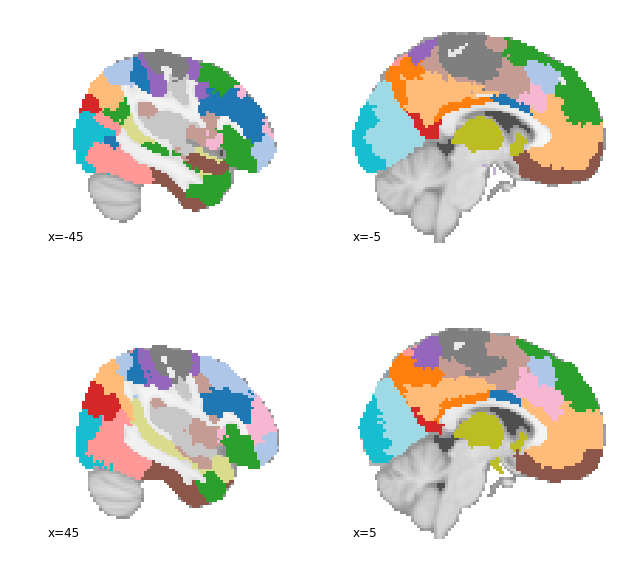

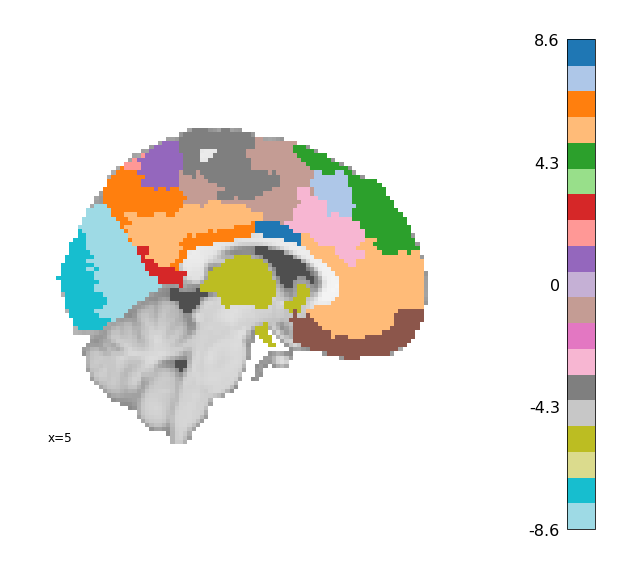

In [10]:
atlas_vals=np.subtract(np.mean(sch_nums),sch_nums)
colormap='tab20_r'
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(10,10))
ax[0,0]=plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax[0,0],
       cut_coords=[-45],colormap=colormap,colorbar=False)
ax[0,1]=plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax[0,1],
       cut_coords=[-5],colormap=colormap,colorbar=False)

ax[1,0]=plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax[1,0],
       cut_coords=[45],colormap=colormap,colorbar=False)
ax[1,1]=plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax[1,1],
       cut_coords=[5],colormap=colormap,colorbar=False)

plt.savefig('{}/fig1b_schaefer_atlas_yeo17_no_cbar.svg'.format(path_Figures))

fig,ax=plt.subplots(figsize=(10,10))
plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax,
       cut_coords=[5],colormap=colormap,colorbar=True)
plt.savefig('{}/fig1b_schaefer_atlas_yeo17_cbar.svg'.format(path_Figures))

# Figure 1C: WB-PPI flowchart

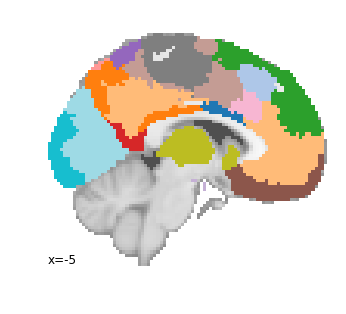

In [11]:
# Plot atlas image

atlas_vals=np.subtract(np.mean(sch_nums),sch_nums)
colormap='tab20_r'
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,5))

ax=plot_atlas_fig(row_means=atlas_vals,
       mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',axes=ax,
       cut_coords=[-5],colormap=colormap,colorbar=False)

plt.savefig('{}/fig1c_schaefer_atlas_yeo17_midline_no_cbar.svg'.format(path_Figures))

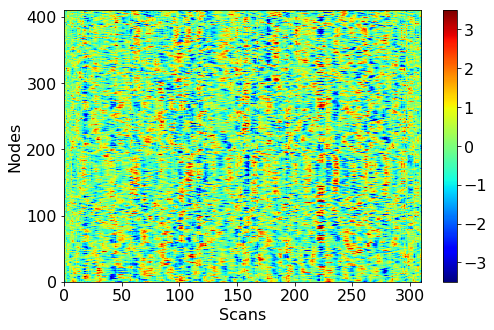

In [49]:
# Plot timeseries bars
path_tsData = opj(data_dir,'timeSeries','netLearn_cfr_schaefer')

def load_sub_data(subjID,runID):
    #subjID and runID are strings to pass to filename
    #file is an npz file with an n_trs x n_nodes matrix (so it is a 2D matrix with stacked timeseries)
    loadFile1=opj(path_tsData, ('{}_netLearn_{}_TS_CorrelationMat_Schaefer400+Subcort.npz'.format(subjID,runID)))
    data=np.load(loadFile1)
    timeseries=data['arr_0']
    return timeseries

ts_mat=load_sub_data('SNL_002','run1')

def plot_ts_mat(timeseries, savename):
    # takes input timeseries [nsamples, nnodes] and FD parameters as input
    # have to be same length!
    
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,5))
    plt.imshow(timeseries.T, interpolation="none", cmap = 'jet', aspect='auto', clim=(-3.5, 3.5))    
    plt.colorbar()
    
    ax.grid(b=False) 
    ax.set_ylim(0,len(timeseries.T))
    #ax.set_title('BOLD Values')
    ax.set_ylabel('Nodes')
    ax.set_xlabel('Scans')
    plt.savefig('{}/{}'.format(path_Figures,savename))
    plt.show()

plot_ts_mat(ts_mat,'fig1c_timeseries.svg')

In [13]:
# Plot WB-PPI matrix
def plot_connMat(myarray,sys_numbers,sys_names,pvals=None,thresh=False,alpha=0.05,filt=False,
                 save=False,figName='test',cmap='RdBu_r',vrange='SDplot',figtype='svg'):
    '''
    Plots connectivity matrix and sorts by system
    Assumes symmetric connectivity

    Parameters
    ----------
       myarray: numpy.ndarray
            matrix with shape (n_nodes,n_nodes) specifying pairwise connectivity between edges
            or
            matrix with shape (n_conn,) representing the vector of unique edges
       sys_numbers: numpy.ndarray
            vector with shape (n_nodes,) specifying system assignments for each node
        sys_names: numpy.ndarray
            vector with shape (n_nodes,) specifying names of systems. Must match order of sys_numbers
    
    Optional Inputs
    _______________
        save: boolean
            if save==True, then save the connectivity matrix as a png image
        figName: character string
            if save==True, save the file in the path_Figures folder with figName   
        cmap: character string
            defaults to red blue range see matplotlib cmaps for options
        vrange: tuple or character string
            default is 'SDplot' which sets the vmin and vmax to +/- 3 standard deviations from 0
            can also manually set with tuple e.g. (-1,1)
        
    '''
    
    bounds,ixes=bct.grid_communities(sys_numbers.astype('int'))       
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8), facecolor='white')
    #fig.suptitle('Connectivity during Go/No-Go task', fontsize=24)
    if len(vrange)==2:
        vmin=min(vrange)
        vmax=max(vrange)
    else:
        vmin=-(3*np.std(myarray))
        vmax = (3*np.std(myarray))

    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    myarray[myarray==inf]=ss.norm.ppf(.9995)
    myarray[myarray==-inf]=ss.norm.ppf(.0005)

    #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
    #a less arbitrary z=3.29 or z=-3.29
    #which should be greater than max value so long as len(null_dist)<2000
    myarray[myarray==4]=ss.norm.ppf(.9995)
    myarray[myarray==-4]=ss.norm.ppf(.0005)
    
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pvals,alpha)
        zMat=conv_cfg_vec_to_adj_matr(np.multiply(myarray,reject_fdr))
    else:
        zMat=conv_cfg_vec_to_adj_matr(myarray)
    if filt=='Pos':
        zMat[zMat<0]=0
    elif filt=='Neg':
        zMat[zMat>0]=0
        
    im= ax1.imshow(zMat[np.ix_(ixes,ixes)],interpolation='none',cmap=cmap, vmin = vmin, vmax = vmax);
    #for b in bounds:
    #      ax1.axvline(x=b,color='red')
    #      ax1.axhline(y=b,color='red')
    
    bounds1=np.hstack((np.array(0.5),bounds))
    bticks=np.zeros(len(bounds))
    for ix,xx in enumerate(bounds):
        bticks[ix]=(bounds1[ix+1]+bounds1[ix])/2
    
    ax1.grid(False);
    plt.xticks(bticks,sys_names)
    plt.yticks(bticks,sys_names)
    ax1.tick_params(axis='both', labelsize=16)
    #for item in ax1.get_yticklabels():
    #    item.set_rotation(20)
    for item in ax1.get_xticklabels():
        item.set_rotation(90)
    cbar = plt.colorbar(im, ax = ax1, shrink = 0.7)
    cbar.ax.tick_params(labelsize=16) 
    #ax1.set_title(figTitle)
    plt.tight_layout()
    if save:
        plt.savefig('{}/{}.{}'.format(path_Figures,figName,figtype))

def load_mats(filefolder,filename):
    data_1=np.load(opj(filefolder,filename))
    if len(data_1['zMat'].shape)>1:
        zMat_1=np.array([conv_cfg_vec_to_adj_matr(data_1['zMat'][x,:]) for x in range(data_1['zMat'].shape[0])])
        pMat_1=np.array([conv_cfg_vec_to_adj_matr(data_1['pMat'][x,:]) for x in range(data_1['pMat'].shape[0])])
    else:
        zMat_1=conv_cfg_vec_to_adj_matr(data_1['zMat'])
        pMat_1=conv_cfg_vec_to_adj_matr(data_1['pMat'])
    return zMat_1,pMat_1


In [14]:
# Load group-level z-scored connectivity matrices
ns_zMat_g,ns_pMat_g=load_mats(path_OutpData,'netLearn_NSData_zscores_26subjs_connmat.npz')
soc_zMat_g,soc_pMat_g=load_mats(path_OutpData,'netLearn_SocData_zscores_26subjs_connmat.npz')
diff_zMat_g,diff_pMat_g=load_mats(path_OutpData,'netLearn_diffData_zscores_26subjs_connmat.npz')
comb_zMat_g,comb_pMat_g=load_mats(path_OutpData,'netLearn_combData_zscores_26subjs_connmat.npz')

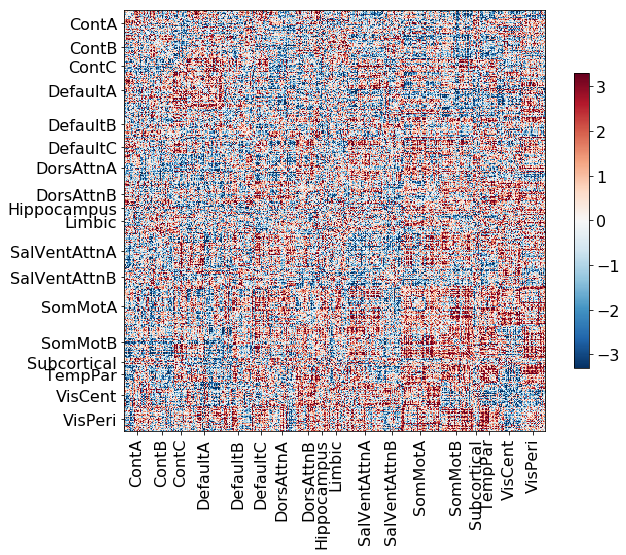

In [67]:
plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_pMat_g,axis=0)).squeeze(),
             filt='None',thresh=False,alpha=0.025,save=True,figName='fig1c_ppi_diff',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='RdBu_r')

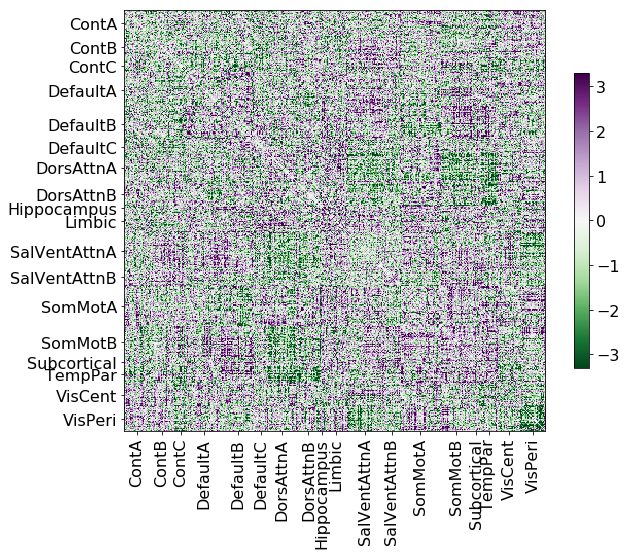

In [68]:
plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='None',thresh=False,alpha=0.025,save=True,figName='fig1c_ppi_comb',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='PRGn_r')

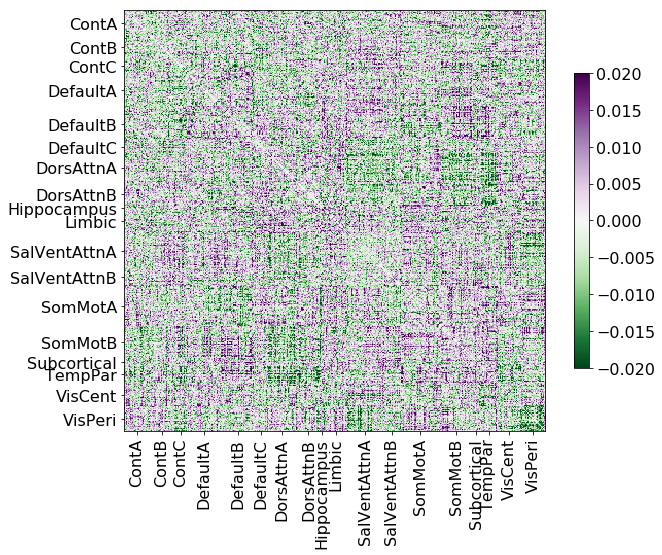

In [74]:
combData=np.mean(np.load('{}/netLearn_comb_transition_PPI_26subjs.npz'.format(path_InpData))['ppiMat'],axis=0)
#adj_mat=conv_cfg_vec_to_adj_matr(combData)
plot_connMat(myarray=combData,
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='None',thresh=False,alpha=0.025,save=True,figName='fig1c_ppi_comb',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-0.02,0.02],cmap='PRGn_r')

In [75]:
# Plot permutation test
def plot_perm_test(test_val,null_dist,figname='test',figtype='svg',save=False):
    '''
    Compute the p-value and z-score for a test value given a null distribution

    Parameters
    ----------
        test_val: float
            numeric value to compare to null distribution
        null_dist: numpy array
            1D array of numeric values to compare with test_val

    Returns
    -------
        zval: float
            z-score of the test_val
        pval: float
            p-value of the test_val
    '''
    pval=ss.percentileofscore(null_dist,test_val)/100
    zval=ss.norm.ppf(pval)
    if pval>0.5:
        pval=(1-pval)
    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    if zval==-inf:
        zval=ss.norm.ppf(.0005)
    elif zval==inf:
        zval=ss.norm.ppf(.9995)
        
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,5))
    plt.hist(np.append(test_val,null_dist),bins=25,color='gray')
    plt.axvline(x=test_val,color='black',linewidth=3)
    #plt.text(x=np.max(null_dist)*.9,y=10,s='P-val={}'.format(pval))
    plt.xlabel('Node Strength')
    plt.ylabel('Number of Permutations')
    #plt.title(plot_title)
    
    if save:
        plt.savefig('{}/{}.{}'.format(path_Figures,figname,figtype))
    plt.show()
    plt.close()
    return zval,pval


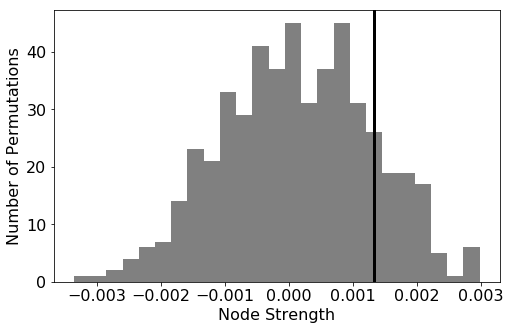

(0.9781502862624715, 0.16400000000000003)

In [76]:
diffData=np.mean(np.load('{}/netLearn_diff_transition_PPI_26subjs.npz'.format(path_InpData))['ppiMat'],axis=0)
null_diffData=np.load('{}/netLearn_diff_nulldata_transition_PPI_26subjs_groupavg.npz'.format(path_NullData))['cfgMat']

#print(diffData.shape)
#print(null_diffData.shape)

# Convert to n_node x n_node matrices
adj_mat=conv_cfg_vec_to_adj_matr(diffData)
null_mat=np.zeros((n_perm,n_node,n_node))
for yy in range(n_perm):
    null_mat[yy,:,:]=conv_cfg_vec_to_adj_matr(null_diffData[yy,:])

# Compute average node strength for each node
rowMeans=np.mean(adj_mat,axis=-1)
null_rowMeans=np.mean(null_mat,axis=-1)


plot_perm_test(rowMeans[407],null_rowMeans[:,407],'fig1c_permtest',save=True)

# Figure 2A: Connectivity Matrix for Transition vs. Non-Transition Contrast

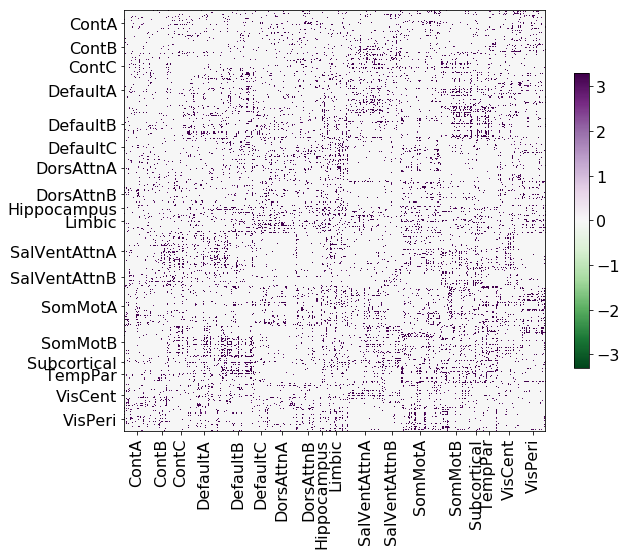

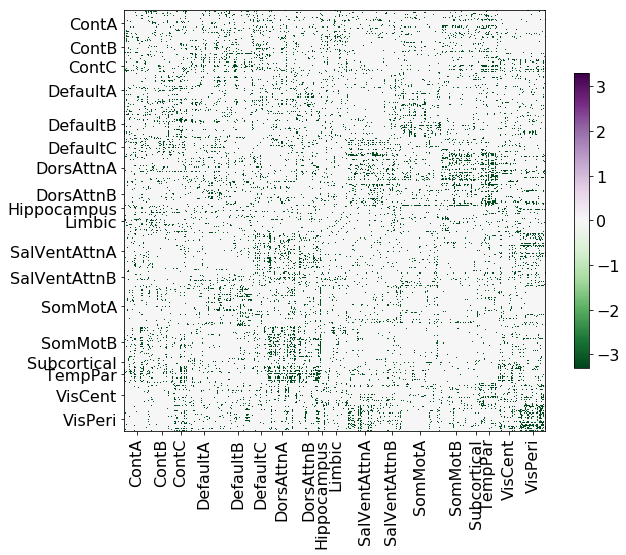

In [79]:
plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='Pos',thresh=True,alpha=0.025,save=True,figName='fig2a_pos',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='PRGn_r')

plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='Neg',thresh=True,alpha=0.025,save=True,figName='fig2a_neg',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='PRGn_r')

# Figure 3A: Connectivity Matrix for Social vs. Non-Social Contrast

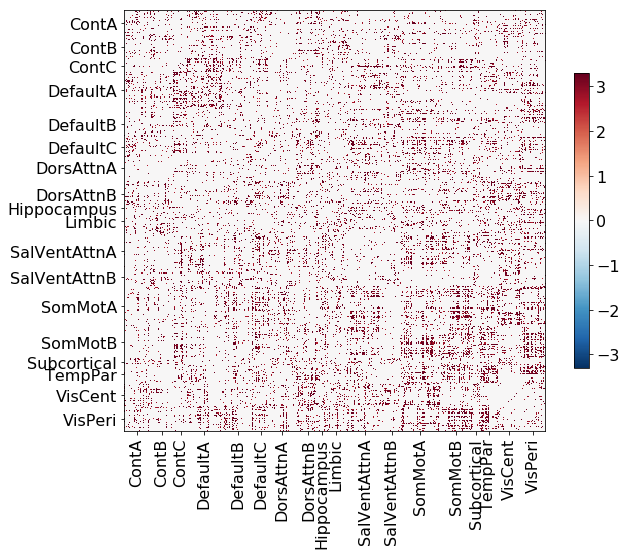

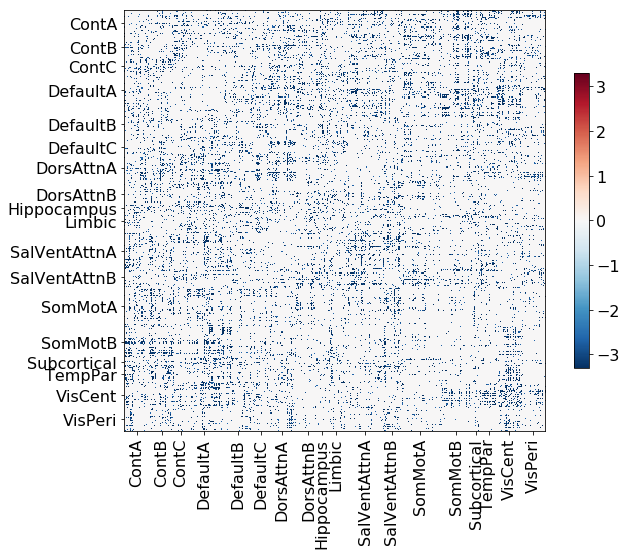

In [80]:
plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_pMat_g,axis=0)).squeeze(),
             filt='Pos',thresh=True,alpha=0.025,save=True,figName='fig3a_pos',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='RdBu_r')

plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_pMat_g,axis=0)).squeeze(),
             filt='Neg',thresh=True,alpha=0.025,save=True,figName='fig3a_neg',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='RdBu_r')

# Figure 2B: Node Strength Brain Maps for Transition vs. Non-Transition Contrast

In [81]:
roi_names=['Hippocampus_L','Hippocampus_R',
               'dmPFC_L','vmPFC_L','PCC_L','TPJ_L',#'Temporal_Sup_L','Temporal_Mid_L',
               'dmPFC_R','vmPFC_R','PCC_R','TPJ_R']#,#'Temporal_Sup_R','Temporal_Mid_R',
               #'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               #'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R']#,
               #'Amygdala_L','Hippocampus_L','Ventral_Striatum_L','Caudate_L',
               #'Amygdala_R','Hippocampus_R','Ventral_Striatum_R','Caudate_R']
        

roi_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L','Hippocampus',
           'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',
           'lPFC_L','Amygdala_L',#'Ventral_Striatum_L','Caudate_L',
           'lPFC_R','Amygdala_R']#,'Ventral_Striatum_R','Caudate_R',]
    
roi_names=sorted(roi_names, key=lambda s: s.lower())

In [82]:
def plot_roi_means(row_means,mask,maskindex,thresh=0,cut_coords=5,figTitle='',colormap='RdBu_r',dmode='x'):
    
    #Get mask data and create blank mask to fill with values
    mdata=mask.get_data()
    img=np.zeros(mdata.shape)
    
    #next, loop over maskindex to assign roi means to voxels in brain mask
    for x in range(len(row_means)):
        roiVal=row_means[x]
        mval=maskindex[x]
        if np.absolute(roiVal)>thresh:
            img[mdata==mval]=roiVal
    
    #Convert mask array to nifti-like image
    mimg=nb.Nifti1Image(img,mask.affine)
    
    #Plot image
    display=plotting.plot_stat_map(mimg, title=figTitle,
                           display_mode=dmode,cut_coords=cut_coords,
                           cmap=colormap,colorbar=True)
    return display


def comb_plot(ix,thresh=False,filt_ix=None,sep=True,alpha=0.05,figtype='svg'):
    xx=list2[ix]
    roidict={}
    #roidf=pd.DataFrame(apriori_names,columns=['ROI'])
    roidf=pd.DataFrame(index=apriori_names)
    for iy,yy in enumerate(list1):
        #'netLearn_SocData_zscores_diffhubs_TPJ_L.npz'
        data=np.load('{}/netLearn_{}_zscores_410nodes_{}.npz'.format(path_OutpData,yy,xx))
        zMat=data['zMat']
        #pMat=np.multiply(data['pMat'],2)
        pMat=data['pMat']
        
        # Set zvals where p=0.00000 to an arbitrary value 
        #in this case p=.0005 and z=3.29 or -3.29, 
        #which should be greater than max value so long as len(null_dist)<2000
        zMat[zMat==inf]=ss.norm.ppf(.9995)
        zMat[zMat==-inf]=ss.norm.ppf(.0005)

        #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
        #a less arbitrary z=3.29 or z=-3.29
        #which should be greater than max value so long as len(null_dist)<2000
        zMat[zMat==4]=ss.norm.ppf(.9995)
        zMat[zMat==-4]=ss.norm.ppf(.0005)


        if thresh:
            reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
            zMat=np.multiply(zMat,reject_fdr)
        if filt_ix:
            zMat[filt_ix]=0
        
        if yy=='diffData' and sep:
            zMat_pos=zMat.copy()
            zMat_pos[zMat_pos<0]=0
            title='{}- {} Connectivity'.format('Social versus Non-Social',list2_labels[ix])
            d1=plot_roi_means(row_means=zMat_pos,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='RdBu_r')
            d2=plot_roi_means(row_means=zMat_pos,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='RdBu_r')
            d1.savefig('{}/{}_{}_soc_lh.{}'.format(path_Figures,yy,xx,figtype))
            d2.savefig('{}/{}_{}_soc_rh.{}'.format(path_Figures,yy,xx,figtype))
            
            zMat_neg=zMat.copy()
            zMat_neg[zMat_neg>0]=0
            title='{}- {} Connectivity'.format('Non-Social versus Social',list2_labels[ix])
            d1=plot_roi_means(row_means=zMat_neg,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='RdBu_r')
            d2=plot_roi_means(row_means=zMat_neg,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='RdBu_r')
            d1.savefig('{}/{}_{}_ns_lh.{}'.format(path_Figures,yy,xx,figtype))
            d2.savefig('{}/{}_{}_ns_rh.{}'.format(path_Figures,yy,xx,figtype))
        else:
            title='{}- {} Connectivity'.format(list1_labels[iy],list2_labels[ix])
            d1=plot_roi_means(row_means=zMat,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='PRGn_r')
            d2=plot_roi_means(row_means=zMat,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='PRGn_r')
            d1.savefig('{}/{}_{}_lh.{}'.format(path_Figures,yy,xx,figtype))
            d2.savefig('{}/{}_{}_rh.{}'.format(path_Figures,yy,xx,figtype))

        #print('')
        roidict[yy]=get_sig_rois(zMat,schaefer_atlas)
        roidf['{}_{}_pos'.format(yy,xx)]=0
        roidf['{}_{}_neg'.format(yy,xx)]=0
        for ir,rr in enumerate(roidf.index):
            if rr in roidict[yy]['pos'].values:
                roidf.loc[rr,'{}_{}_pos'.format(yy,xx)]=1
            if rr in roidict[yy]['neg'].values:
                roidf.loc[rr,'{}_{}_neg'.format(yy,xx)]=1
            
    return roidict,roidf




def get_sig_rois(zMat,atlas):
    pix=np.where(zMat>0)[0]
    nix=np.where(zMat<0)[0]
    pos_rois=atlas.loc[pix,'ns_ROI_label']
    neg_rois=atlas.loc[nix,'ns_ROI_label']
    return {'pos':pos_rois,'neg':neg_rois}
        

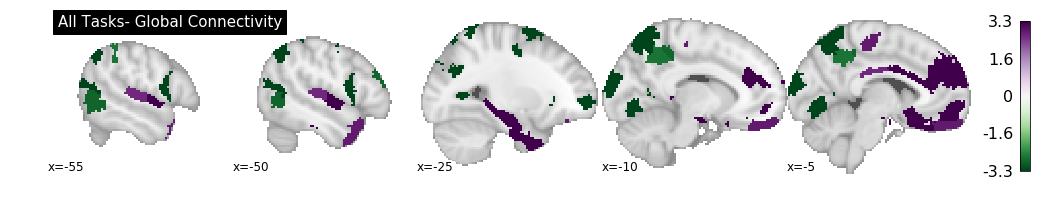

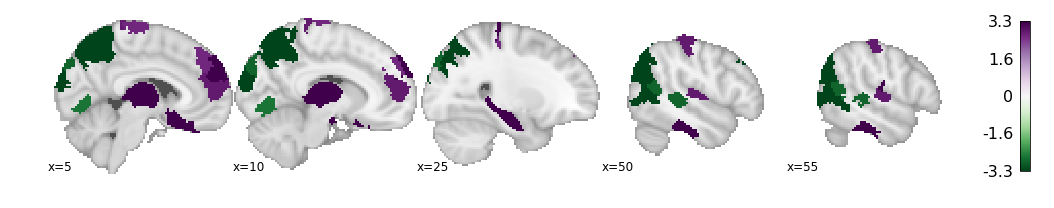

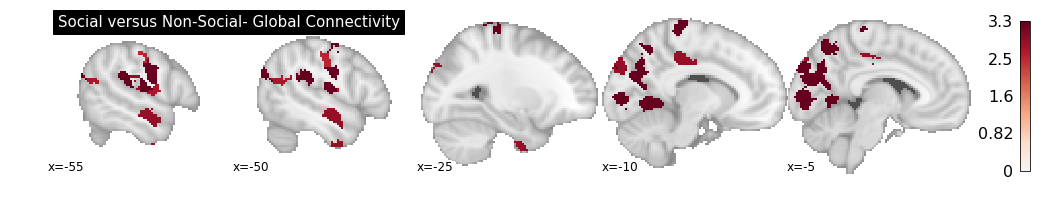

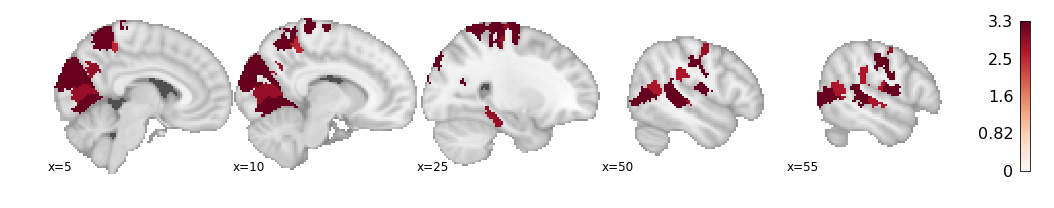

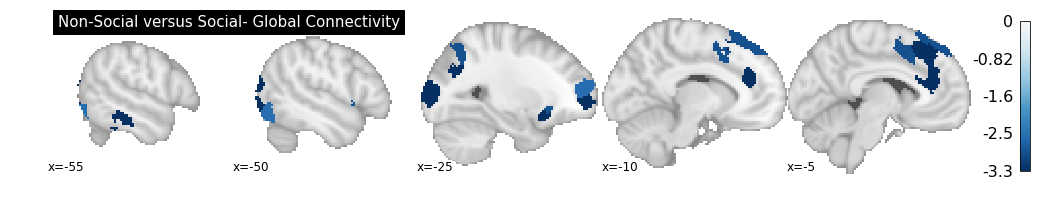

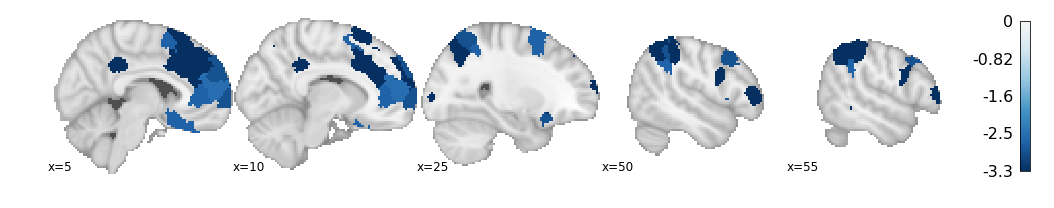

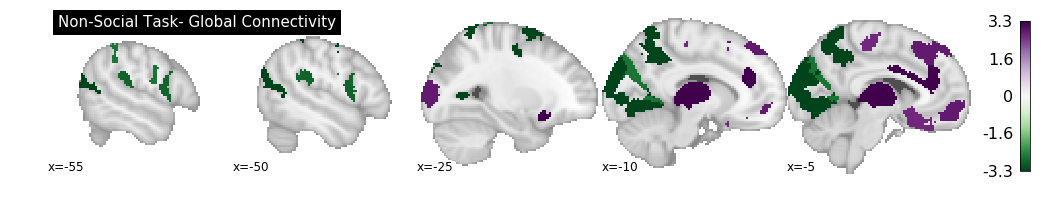

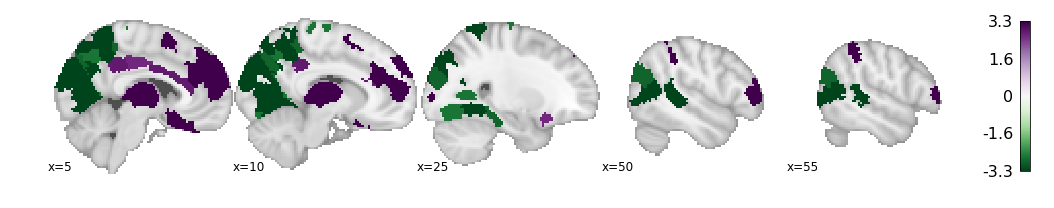

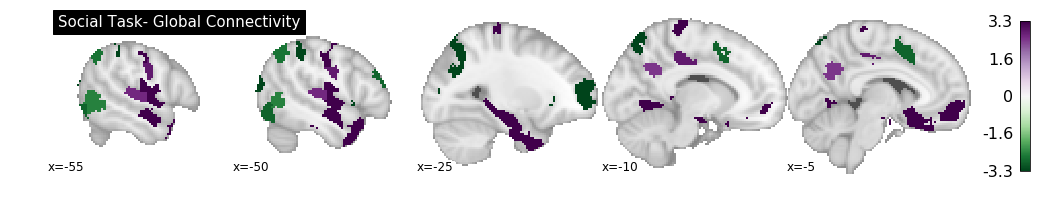

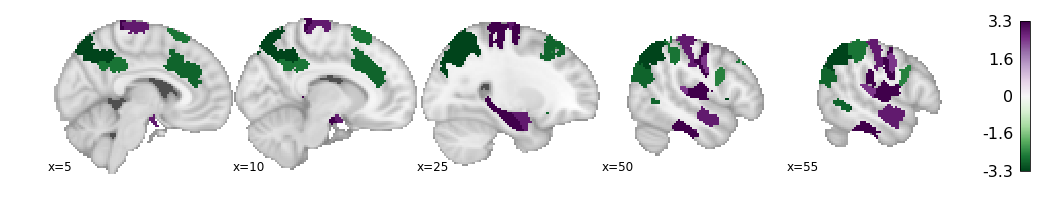

In [83]:
roi_dict,roi_df=comb_plot(0,thresh=True,alpha=0.025)

# Figure 2C: System percentages for transition versus non-transition contrast

In [84]:
def count_hubs(sig_ix,sys_list,print_counts=False):
    cog_sys_names=np.unique(sys_list)
    hcount=[np.sum(np.where(sys_list[sig_ix]==cname,1,0)) for cname in cog_sys_names]
    if print_counts:
        print(zip(cog_sys_names,hcount))
    return hcount

def hub_sys_test(atlas_df,sig_ix,system_column,n_perm=500):
    cog_sys_names=np.unique(atlas_df[system_column])
    
    #Get count of number of hubs in each system
    hcount=count_hubs(sig_ix,atlas_df[system_column])
    n_nodes=len(atlas_df)
    sys_size=count_hubs(range(n_nodes),atlas_df[system_column])
    hpercent=np.divide(hcount,sys_size,dtype='float')
    
    perm_labels=schaefer_atlas['System'].values.copy()
    hcount_null=np.zeros((len(hcount),n_perm))
    hpercent_null=np.zeros((len(hpercent),n_perm))
    for pp in range(n_perm):
        shuffle(perm_labels)
        hcount_null[:,pp]=count_hubs(sig_ix,perm_labels)
        hpercent_null[:,pp]=np.divide(count_hubs(sig_ix,perm_labels),sys_size,dtype='float')
    
    zvals1=np.zeros(len(cog_sys_names))
    zvals2=np.zeros(len(cog_sys_names))
    pvals1=np.ones(len(cog_sys_names))
    pvals2=np.ones(len(cog_sys_names))
    for sys in range(len(hcount)):
        zvals1[sys],pvals1[sys]=compute_pval_twotail(hcount[sys],hcount_null[sys,:])
        zvals2[sys],pvals2[sys]=compute_pval_twotail(hpercent[sys],hpercent_null[sys,:])
        
    sys_dict={'hub_count':hcount,'hub_percent':hpercent,
            'zvals_count':zvals1,'zvals_percent':zvals2,
            'pvals_count':pvals1,'pvals_percent':pvals2,
             'null_count':hcount_null,'null_percent':hpercent_null}
    return sys_dict
        
def loop_hub_sys_test(atlas_df,system_column,n_perm=500):
    #Create dataframe to fill with system counts
    cog_sys_names=np.unique(atlas_df[system_column])

    comb_dict=hub_sys_test(atlas_df,sigvals_comb_all,system_column,n_perm)
    comb_neg_dict=hub_sys_test(atlas_df,sigvals_comb_neg_all,system_column,n_perm)
    soc_dict=hub_sys_test(atlas_df,sigvals_soc_all,system_column,n_perm)
    ns_dict=hub_sys_test(atlas_df,sigvals_ns_all,system_column,n_perm)    
    
    n_nodes=len(atlas_df)
    sys_size=count_hubs(range(n_nodes),atlas_df[system_column])
    
    sys_df=pd.DataFrame(cog_sys_names,columns=['System'])
    sys_df['Sys_Size']=sys_size
    sys_df['Comb_Count']=comb_dict['hub_count']
    sys_df['Comb_Neg_Count']=comb_neg_dict['hub_count']
    sys_df['Soc_Count']=soc_dict['hub_count']
    sys_df['NS_Count']=ns_dict['hub_count']
    sys_df['Comb_Percent']=comb_dict['hub_percent']
    sys_df['Comb_Neg_Percent']=comb_neg_dict['hub_percent']
    sys_df['Soc_Percent']=soc_dict['hub_percent']
    sys_df['NS_Percent']=ns_dict['hub_percent']
    
    sys_df['Comb_Count_zvals']=comb_dict['zvals_count']
    sys_df['Comb_Neg_Count_zvals']=comb_neg_dict['zvals_count']
    sys_df['Soc_Count_zvals']=soc_dict['zvals_count']
    sys_df['NS_Count_zvals']=ns_dict['zvals_count']
    sys_df['Comb_Percent_zvals']=comb_dict['zvals_percent']
    sys_df['Comb_Neg_Percent_zvals']=comb_neg_dict['zvals_percent']
    sys_df['Soc_Percent_zvals']=soc_dict['zvals_percent']
    sys_df['NS_Percent_zvals']=ns_dict['zvals_percent']
    
    sys_df['Comb_Count_pvals']=comb_dict['pvals_count']
    sys_df['Comb_Neg_Count_pvals']=comb_neg_dict['pvals_count']
    sys_df['Soc_Count_pvals']=soc_dict['pvals_count']
    sys_df['NS_Count_pvals']=ns_dict['pvals_count']
    sys_df['Comb_Percent_pvals']=comb_dict['pvals_percent']
    sys_df['Comb_Neg_Percent_pvals']=comb_neg_dict['pvals_percent']
    sys_df['Soc_Percent_pvals']=soc_dict['pvals_percent']
    sys_df['NS_Percent_pvals']=ns_dict['pvals_percent'] 
    
    sys_df['Soc_vs_NS_Count']=np.array(soc_dict['hub_count'])-np.array(ns_dict['hub_count'])
    sys_df['Soc_vs_NS_Percent']=np.array(soc_dict['hub_percent'])-np.array(ns_dict['hub_percent'])
    
    diff_null_count=np.array(soc_dict['null_count'])-np.array(ns_dict['null_count'])
    diff_null_percent=np.array(soc_dict['null_percent'])-np.array(ns_dict['null_percent'])

    sys_df['Soc_vs_NS_Count_zvals']=0
    sys_df['Soc_vs_NS_Count_pvals']=0
    
    sys_df['Soc_vs_NS_Percent_zvals']=0
    sys_df['Soc_vs_NS_Percent_pvals']=0
    
    for nn,name in enumerate(cog_sys_names):    
        zval1,pval1=compute_pval_twotail(sys_df.loc[nn,'Soc_vs_NS_Count'],diff_null_count[nn,:])
        zval2,pval2=compute_pval_twotail(sys_df.loc[nn,'Soc_vs_NS_Percent'],diff_null_percent[nn,:])
        sys_df.loc[nn,'Soc_vs_NS_Count_zvals']=zval1
        sys_df.loc[nn,'Soc_vs_NS_Count_pvals']=pval1
        sys_df.loc[nn,'Soc_vs_NS_Percent_zvals']=zval2
        sys_df.loc[nn,'Soc_vs_NS_Percent_pvals']=pval2


    null_dict={'comb_null_count':comb_dict['null_count'],'comb_null_percent':comb_dict['null_percent'],
               'comb_neg_null_count':comb_neg_dict['null_count'],'comb_neg_null_percent':comb_neg_dict['null_percent'],
               'soc_null_count':soc_dict['null_count'],'soc_null_percent':soc_dict['null_percent'],
               'ns_null_count':ns_dict['null_count'],'ns_null_percent':ns_dict['null_percent'],
               'diff_null_count':diff_null_count,'diff_null_percent':diff_null_percent}
              
    return sys_df,null_dict

In [85]:
def get_hubs(xx,yy,thresh=True,apriori=True,flip=False,alpha=0.025):
    '''
    Identify hubs given a set of z-scores and p-values for connectivity

    Parameters
    ----------
        xx: character string
            string indicating which task to load data for
        yy: character string
            string indicating which connectivity z-scores to load
        atlas: pandas dataframe
            2D pandas df with atlas information (node ids and labels)
        atlas_labels: character string
            string indicating which column in atlas to use for roi names
        roi_names: list
            list indicating which rois to consider for significant test
        title: character string
            title to include in printing results
        thresh: boolean
            boolean indicating whether to apply FDR correction
            if True, also need to set alpha (default=0.05)
        apriori: boolean
            boolean indicating whether to only include 
        flip:
            boolean indicating whether to flip the z-scores 
            which would identify hubs with sig negative z-scores
        alpha: float
            numeric value indicating the p-value threshold to apply to FDR correction

    Returns
    -------
        sig_ix: list
            output description
        sig_vec: numpy array
            1D n_nodes array where 0 indicates a non-hub and 1 indicates a significant hub
        sig_dic: dictionary
            dictionary with keys indicating the indices for significant hubs for each ROI
    '''    
    zMat,pMat=load_zscores(xx,yy)
    sigvals,sigvec,sigdic=identify_hubs2(pMat,zMat,schaefer_atlas,'ns_ROI_label',apriori_names,
                                        title='Significant Hubs for {}: {}'.format(xx,yy),
                                        thresh=thresh,apriori=apriori,flip=flip,alpha=alpha)
    return sigvals,sigvec,sigdic

def load_zscores(xx,yy):
    '''
    Identify hubs given a set of z-scores and p-values for connectivity

    Parameters
    ----------
        xx: character string
            string indicating which task to load data for
        yy: character string
            string indicating which connectivity z-scores to load

    Returns
    -------
        zMat: numpy array
            1D n_nodes numpy array of z-scores
        pMat: numpy array
            1D n_nodes numpy array of p-values
    '''
    data=np.load('{}/netLearn_{}_zscores_410nodes_{}.npz'.format(path_OutpData,xx,yy))
    zMat=data['zMat']
    pMat=data['pMat']
    return zMat,pMat


def identify_hubs2(pMat,zMat,atlas,atlas_labels,roi_names,title='Significant Hubs',
                  thresh=True,apriori=True,flip=False,alpha=0.05):
    '''
    Identify hubs given a set of z-scores and p-values for connectivity

    Parameters
    ----------
        zMat: numpy array
            1D n_nodes numpy array of z-scores
        pMat: numpy array
            1D n_nodes numpy array of p-values
        atlas: pandas dataframe
            2D pandas df with atlas information (node ids and labels)
        atlas_labels: character string
            string indicating which column in atlas to use for roi names
        roi_names: list
            list indicating which rois to consider for significant test
        title: character string
            title to include in printing results
        thresh: boolean
            boolean indicating whether to apply FDR correction
            if True, also need to set alpha (default=0.05)
        apriori: boolean
            boolean indicating whether to only include 
        flip:
            boolean indicating whether to flip the z-scores 
            which would identify hubs with sig negative z-scores
        alpha: float
            numeric value indicating the p-value threshold to apply to FDR correction

    Returns
    -------
        sig_ix: list
            output description
        sig_vec: numpy array
            1D n_nodes array where 0 indicates a non-hub and 1 indicates a significant hub
        sig_dic: dictionary
            dictionary with keys indicating the indices for significant hubs for each ROI
    '''
    if flip:
        zMat=np.multiply(zMat,-1)
        
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)

    sig_ix=np.where(zMat>0)[0]
    sig_dic={}
    sig_vec=np.zeros(zMat.shape)
    if apriori:
        sig_ix=[x for x in sig_ix if atlas.loc[x,atlas_labels] in roi_names]
        for i,x in enumerate(roi_names):
            sig_dic[x]=[ix for ix in sig_ix if atlas.loc[ix,atlas_labels]==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)
    else:
        sig_rois=np.unique([schaefer_atlas.loc[ix,] for ix in sig_ix])
        for i,x in enumerate(sig_rois):
            sig_dic[x]=[ix for ix in sig_ix if atlas.loc[ix,atlas_labels]==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)
    sig_vec[sig_ix]=1
        
    print('')
    print(title)
    print('{} significant positive ROIs in a priori regions'.format(len(sig_ix)))
    return sig_ix,sig_vec,sig_dic


def compute_pval_twotail(test_val,null_dist,plot=False,plot_title=''):
    '''
    Compute the p-value and z-score for a test value given a null distribution

    Parameters
    ----------
        test_val: float
            numeric value to compare to null distribution
        null_dist: numpy array
            1D array of numeric values to compare with test_val
        plot: boolean
            boolean indicating whether to plot the distribution

    Returns
    -------
        zval: float
            z-score of the test_val
        pval: float
            p-value of the test_val
    '''
    pval=ss.percentileofscore(null_dist,test_val)/100
    zval=ss.norm.ppf(pval)
    if pval>0.5:
        pval=(1-pval)
    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    if zval==-inf:
        zval=ss.norm.ppf(.0005)
    elif zval==inf:
        zval=ss.norm.ppf(.9995)
    if plot:
        plt.hist(np.append(test_val,null_dist),bins=50)
        plt.axvline(x=test_val,color='black')
        plt.text(x=np.max(null_dist)*.9,y=10,s='P-val={}'.format(pval))
        plt.title(plot_title)
        plt.show()
        plt.close()
    return zval,pval

In [86]:
sigvals_comb_all,sigvec_comb_all,sigdic_comb_all=get_hubs('combData','all',
                                              thresh=True,apriori=False,flip=False,alpha=0.025)
signames_comb_all=schaefer_atlas.loc[sigvals_comb_all,'ns_ROI_label']

sigvals_comb_neg_all,sigvec_comb_neg_all,sigdic_comb_neg_all=get_hubs('combData','all',
                                              thresh=True,apriori=False,flip=True,alpha=0.025)
signames_comb_neg_all=schaefer_atlas.loc[sigvals_comb_neg_all,'ns_ROI_label']

sigvals_soc_all,sigvec_soc_all,sigdic_soc_all=get_hubs('diffData','all',
                                              thresh=True,apriori=False,flip=False,alpha=0.025)
signames_soc_all=schaefer_atlas.loc[sigvals_soc_all,'ns_ROI_label']

sigvals_ns_all,sigvec_ns_all,sigdic_ns_all=get_hubs('diffData','all',
                                              thresh=True,apriori=False,flip=True,alpha=0.025)
signames_ns_all=schaefer_atlas.loc[sigvals_ns_all,'ns_ROI_label']

/Users/steventompson/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:283: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  ar.sort()



Significant Hubs for combData: all
36 significant positive ROIs in a priori regions

Significant Hubs for combData: all
49 significant positive ROIs in a priori regions

Significant Hubs for diffData: all
63 significant positive ROIs in a priori regions

Significant Hubs for diffData: all
55 significant positive ROIs in a priori regions


In [87]:
df1,dict1=loop_hub_sys_test(schaefer_atlas,'System')

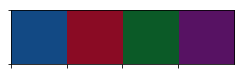

In [88]:
# Set up figure formatting
custom_palette=[(0.071280276816609, 0.2878892733564014, 0.518800461361015),#Blue
                (0.5423298731257209, 0.044290657439446365, 0.1437139561707036),#Red
                (0.045674740484429065, 0.35463283352556707, 0.1532487504805844),#Green
                (0.3423298731257211, 0.07104959630911206, 0.3888504421376396)]#Purple

sns.palplot(custom_palette)

sys_labels=['Control A','Control B','Control C',
            'Default A','Default B','Default C',
            'Dorsal Attention A','Dorsal Attention B',
            'Hippocampus','Limbic',
            'Ventral Attention A','Ventral Attention B',
            'Somatomotor A','Somatomotor B',
            'Subcortical','Temporoparietal',
            'Central Visual','Peripheral Visual']

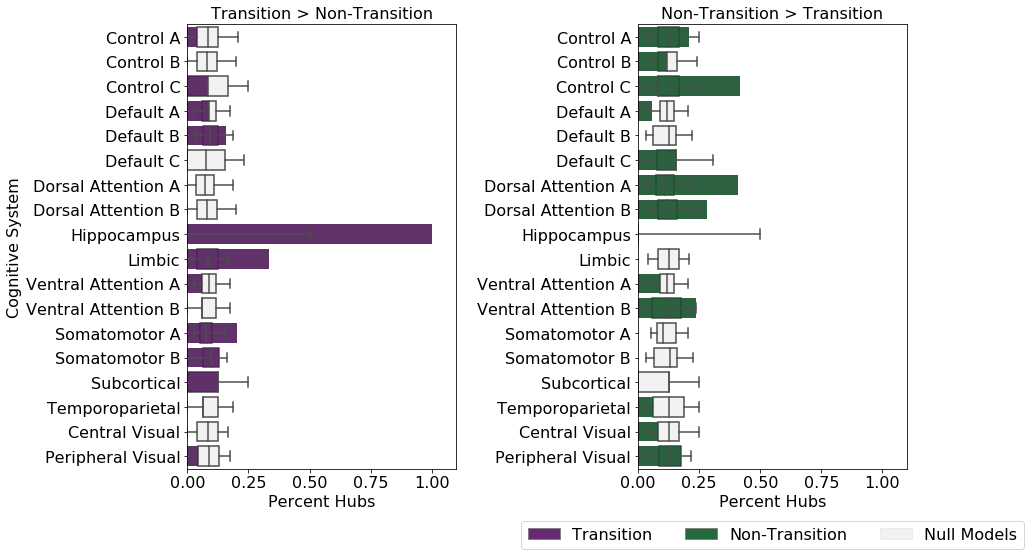

In [89]:
comb_null_df=pd.DataFrame(dict1['comb_null_percent'].T,columns=sys_labels)
comb_neg_null_df=pd.DataFrame(dict1['comb_neg_null_percent'].T,columns=sys_labels)

f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,8))
with sns.color_palette(custom_palette):
    sns.barplot(x='value',y='variable',color=custom_palette[3],
                data=pd.DataFrame(zip(df1['Comb_Percent'],sys_labels),columns=['value','variable']),
                ax=ax1,alpha=0.9)
    sns.boxplot(x='value',y='variable',data=pd.melt(comb_null_df),
                #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
                whis=[5,95],fliersize=0,color='gray',ax=ax1)
    
    sns.barplot(x='value',y='variable',color=custom_palette[2],
                data=pd.DataFrame(zip(df1['Comb_Neg_Percent'],sys_labels),columns=['value','variable']),
                ax=ax2,alpha=0.9)
    sns.boxplot(x='value',y='variable',data=pd.melt(comb_neg_null_df),
                #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
                whis=[5,95],fliersize=0,color='gray',ax=ax2)
    for patch in ax1.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.1))
        
    for patch in ax2.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.1))

    ax1.set_xlim(0, 1.1)
    ax2.set_xlim(0, 1.1)
    #f.subplots_adjust(wspace=0.6)
    ax1.set(xlabel='Percent Hubs', ylabel='Cognitive System',title='Transition > Non-Transition')
    ax2.set(xlabel='Percent Hubs', ylabel='',title='Non-Transition > Transition')
    
    from matplotlib.patches import Patch

    legend_elements = [Patch(facecolor=custom_palette[3],edgecolor='gray',label='Transition',alpha=0.9),
                       Patch(facecolor=custom_palette[2],edgecolor='gray',label='Non-Transition',alpha=0.9),
                      Patch(facecolor='gray',edgecolor='gray',label='Null Models',alpha=0.1)]

    #ax1.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
    ax2.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
    plt.tight_layout()
    plt.savefig('{}/fig2c.svg'.format(path_Figures))

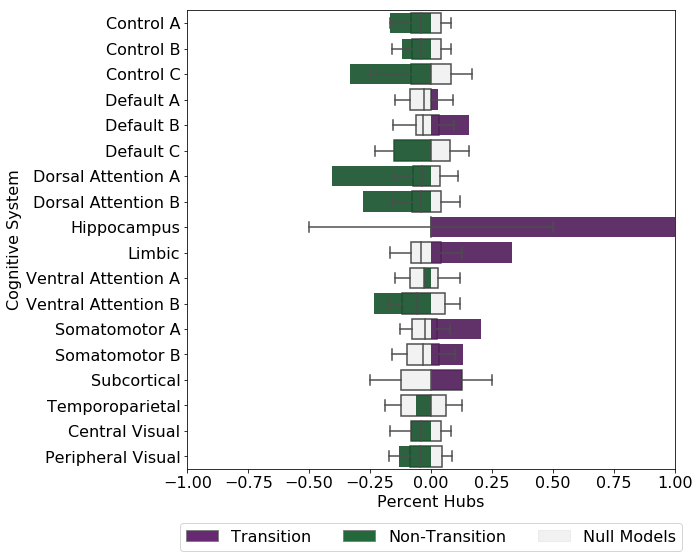

In [90]:
comb_diff_null_df=pd.DataFrame(dict1['comb_null_percent'].T,columns=sys_labels)-pd.DataFrame(dict1['comb_neg_null_percent'].T,columns=sys_labels)

comb_diff=df1['Comb_Percent'].values.copy()-df1['Comb_Neg_Percent'].values.copy()
pos_diff=comb_diff.copy()
neg_diff=comb_diff.copy()
pos_diff[pos_diff<0]=0
neg_diff[neg_diff>0]=0

fig, ax = plt.subplots(figsize=(10,8))
l1=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(pos_diff,sys_labels),columns=['value','variable']),
            color=custom_palette[3],ax=ax,alpha=0.9)
l2=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(neg_diff,sch_names),columns=['value','variable']),
            color=custom_palette[2],ax=ax,alpha=0.9)
l3=sns.boxplot(x='value',y='variable',data=pd.melt(comb_diff_null_df),
            #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
            whis=[5,95],fliersize=0,color='gray',ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
    #patch.set_linewidth(0.1)
    #r, g, b, a = patch.get_edgecolor()
    #patch.set_edgecolor((r, g, b, .1))
plt.xlim(-1, 1)
#plt.legend([l1, l2],["Non-Social", "Social"])

from matplotlib.patches import Patch

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(handles=legend_elements,loc='lower left', bbox_to_anchor=(1, 0.5))

legend_elements = [Patch(facecolor=custom_palette[3],edgecolor='gray',label='Transition',alpha=0.9),
                  Patch(facecolor=custom_palette[2],edgecolor='gray',label='Non-Transition',alpha=0.9),
                  Patch(facecolor='gray',edgecolor='gray',label='Null Models',alpha=0.1)]

ax.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
ax.set(xlabel='Percent Hubs', ylabel='Cognitive System')
plt.tight_layout()
plt.savefig('{}/fig2c-combined.svg'.format(path_Figures))



# Figure 3C: System percentages for transition versus non-transition contrast

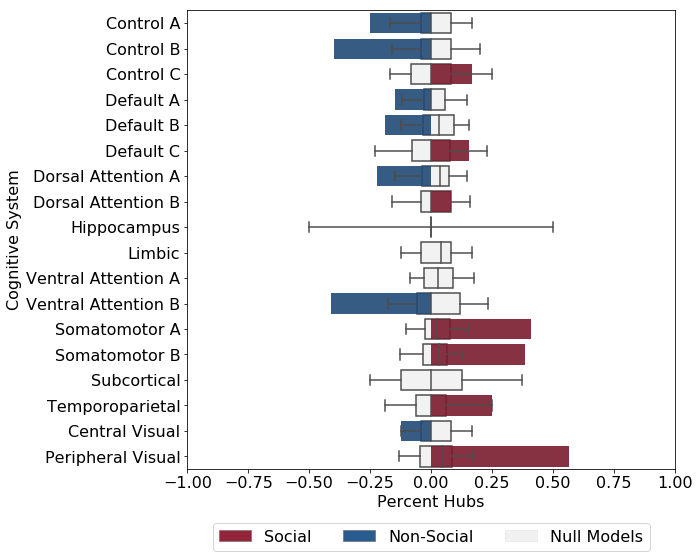

In [91]:
diff_null_df=pd.DataFrame(dict1['diff_null_percent'].T,columns=sys_labels)

pos_diff=df1['Soc_vs_NS_Percent'].values.copy()
neg_diff=df1['Soc_vs_NS_Percent'].values.copy()
pos_diff[pos_diff<0]=0
neg_diff[neg_diff>0]=0

fig, ax = plt.subplots(figsize=(10,8))
l1=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(pos_diff,sys_labels),columns=['value','variable']),
            color=custom_palette[1],ax=ax,alpha=0.9)
l2=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(neg_diff,sch_names),columns=['value','variable']),
            color=custom_palette[0],ax=ax,alpha=0.9)
l3=sns.boxplot(x='value',y='variable',data=pd.melt(diff_null_df),
            #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
            whis=[5,95],fliersize=0,color='gray',ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
    #patch.set_linewidth(0.1)
    #r, g, b, a = patch.get_edgecolor()
    #patch.set_edgecolor((r, g, b, .1))
plt.xlim(-1, 1)
#plt.legend([l1, l2],["Non-Social", "Social"])

from matplotlib.patches import Patch

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(handles=legend_elements,loc='lower left', bbox_to_anchor=(1, 0.5))

legend_elements = [Patch(facecolor=custom_palette[1],edgecolor='gray',label='Social',alpha=0.9),
                  Patch(facecolor=custom_palette[0],edgecolor='gray',label='Non-Social',alpha=0.9),
                  Patch(facecolor='gray',edgecolor='gray',label='Null Models',alpha=0.1)]

ax.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
ax.set(xlabel='Percent Hubs', ylabel='Cognitive System')
plt.tight_layout()
plt.savefig('{}/fig3c.svg'.format(path_Figures))



# Figure 2D: System-Level Connectivity Matrix for Transition vs. Non-Transition Contrast

In [92]:
def get_means2(cfg_mat,row_ix,col_ix):
    '''
    Computes the mean connectivity for each subject for a given set of nodes

    Parameters
    ----------
        cfg_mat: numpy array
            2D n_subjs x n_conn np array OR
            3D n_subjs x n_node x n_node np array
        row_ix: list
            row indices to include in the means to extract
        col_ix: list
            col indices to include in the means to extract

    Returns
    -------
        rowMeans: numpy array
            1D n_subjs np array
    '''
    if len(cfg_mat.shape)==3:
        adj_mat=cfg_mat.copy()
    else:
        adj_mat=np.array([conv_cfg_vec_to_adj_matr(cfg_mat[x,:]) for x in range(cfg_mat.shape[0])])
    #adj_mat=np.array([conv_cfg_vec_to_adj_matr(cfg_mat[x,:]) for x in range(cfg_mat.shape[0])])
    subdata=adj_mat[:,row_ix,:]
    subdata=subdata[:,:,col_ix]
    rowMeans=np.mean(subdata,axis=(-1,-2)) #note: how to handle rows that contain the diagonal value?
    return rowMeans

def get_null_means2(cfg_mat,row_ix,col_ix):
    '''
    Computes the mean connectivity for each subject and each null model for a given set of nodes

    Parameters
    ----------
        cfg_mat: numpy array
            3D n_subjs x n_perm x n_conn np array
        row_ix: list
            row indices to include in the means to extract
        col_ix: list
            col indices to include in the means to extract

    Returns
    -------
        rowMeans: numpy array
            2D n_perm x n_subjs np array
    '''
    n_subjs=cfg_mat.shape[0]
    n_perm=cfg_mat.shape[1]
    n_node=conv_cfg_vec_to_adj_matr(cfg_mat[0,0,:]).shape[0]

    adj_mat=np.zeros((n_subjs,n_perm,n_node,n_node))
    for xx in range(n_subjs):
        for yy in range(n_perm):
            adj_mat[xx,yy,:,:]=conv_cfg_vec_to_adj_matr(cfg_mat[xx,yy,:])
    subdata=adj_mat[:,:,row_ix,:]
    subdata=subdata[:,:,:,col_ix]
    rowMeans=np.mean(subdata,axis=(-1,-2)) #note: how to handle rows that contain the diagonal value?
    return rowMeans

def get_sys_zscores(conn_mat,null_mat,node_df,sys_names,colindex,
                    plot=None,print_vals=False,thresh=True,alpha=0.025):
    sys_df=pd.DataFrame(np.zeros((len(sys_names),len(sys_names))))
    sys_df.index=sys_names
    sys_df.columns=sys_names
    sys_df_zvals=sys_df.copy()
    sys_df_pvals=sys_df.copy()
        
    for sys1 in sys_names:
        for sys2 in sys_names:
            sys_ix=[i for i,x in enumerate(node_df[colindex]) if sys1==x]
            sys_iy=[j for j,y in enumerate(node_df[colindex]) if sys2==y]
            #print('{}: {}'.format(sys1,sys_ix))
            #print('{}: {}'.format(sys2,sys_iy))
            sys_mean=get_means2(conn_mat,sys_ix,sys_iy)
            sys_null_dist=get_null_means2(np.expand_dims(null_mat,axis=0),sys_ix,sys_iy)
            sys_z,sys_p=compute_pval_twotail(sys_mean[0],sys_null_dist[0,:])
            if print_vals:
                print('{} x {} z={}, p={}'.format(sys1,sys2,sys_z,sys_p))
            sys_df.loc[sys1,sys2]=sys_mean
            sys_df_zvals.loc[sys1,sys2]=sys_z
            sys_df_pvals.loc[sys1,sys2]=sys_p
            
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(sys_df_pvals,alpha)
        sys_df_zvals_fdr=np.multiply(sys_df_zvals,reject_fdr)
        sys_dict={'sys_df':sys_df,'sys_df_zvals':sys_df_zvals,
                  'sys_df_zvals_fdr':sys_df_zvals_fdr,
                  'sys_df_pvals':sys_df_pvals}
    else:
        sys_dict={'sys_df':sys_df,'sys_df_zvals':sys_df_zvals,'sys_df_pvals':sys_df_pvals}
    if plot=='thresh':
        ax1=plotting.plot_matrix(sys_df_zvals_fdr,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
    elif plot=='unc':
        ax1=plotting.plot_matrix(sys_df_zvals,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
        
    return sys_dict

In [93]:
# Load subject data
diffData=np.load(opj(path_InpData,'netLearn_diff_transition_PPI_26subjs.npz'))
combData=np.load(opj(path_InpData,'netLearn_comb_transition_PPI_26subjs.npz'))

diffMat1=np.expand_dims(np.mean(diffData['ppiMat'],axis=0),axis=0)
combMat1=np.expand_dims(np.mean(combData['ppiMat'],axis=0),axis=0)

# Load null data
comb_nullMat=np.load(opj(path_NullData,'netLearn_comb_nulldata_transition_PPI_26subjs_groupavg.npz'))['cfgMat']
diff_nullMat=np.load(opj(path_NullData,'netLearn_diff_nulldata_transition_PPI_26subjs_groupavg.npz'))['cfgMat']

ContA x ContA z=1.3917437794, p=0.082
ContA x ContB z=-0.606775363514, p=0.272
ContA x ContC z=-3.29052673149, p=0.0
ContA x DefaultA z=-0.186567181837, p=0.426
ContA x DefaultB z=-0.970093276629, p=0.166
ContA x DefaultC z=1.0278933458, p=0.152
ContA x DorsAttnA z=-2.51214432793, p=0.006
ContA x DorsAttnB z=1.30468538523, p=0.096
ContA x Hippocampus z=-0.396142373893, p=0.346
ContA x Limbic z=-1.28155156554, p=0.1
ContA x SalVentAttnA z=-2.05374891063, p=0.02
ContA x SalVentAttnB z=-0.725737024101, p=0.234
ContA x SomMotA z=-0.799500943133, p=0.212
ContA x SomMotB z=-1.62576338623, p=0.052
ContA x Subcortical z=1.52203624174, p=0.064
ContA x TempPar z=-1.53819885858, p=0.062
ContA x VisCent z=0.478913734112, p=0.316
ContA x VisPeri z=0.785773831524, p=0.216
ContB x ContA z=-0.606775363514, p=0.272
ContB x ContB z=1.3917437794, p=0.082
ContB x ContC z=-2.8781617391, p=0.002
ContB x DefaultA z=1.18504412791, p=0.118
ContB x DefaultB z=0.060195411729, p=0.476
ContB x DefaultC z=-1.155220

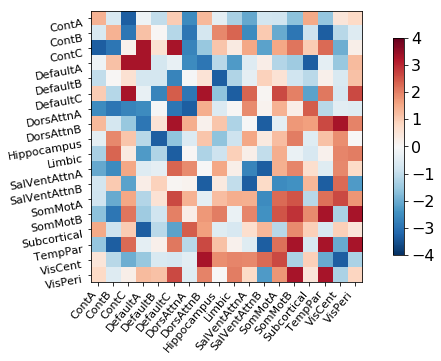

In [94]:
diff_cog_sys_dict=get_sys_zscores(conn_mat=diffMat1,null_mat=diff_nullMat,
                                  node_df=schaefer_atlas,sys_names=sch_names,colindex='System',
                                  plot='unc',print_vals=True,thresh=True,alpha=0.025)

ContA x ContA z=-0.758753544504, p=0.224
ContA x ContB z=-1.6645628612, p=0.048
ContA x ContC z=-0.855995985493, p=0.196
ContA x DefaultA z=-0.606775363514, p=0.272
ContA x DefaultB z=-1.07137688928, p=0.142
ContA x DefaultC z=-1.08934902792, p=0.138
ContA x DorsAttnA z=-0.524400512708, p=0.3
ContA x DorsAttnB z=1.0278933458, p=0.152
ContA x Hippocampus z=-0.970093276629, p=0.166
ContA x Limbic z=-0.337155076995, p=0.368
ContA x SalVentAttnA z=-1.34075503369, p=0.09
ContA x SalVentAttnB z=0.806421247018, p=0.21
ContA x SomMotA z=0.954165253146, p=0.17
ContA x SomMotB z=-1.94313375111, p=0.026
ContA x Subcortical z=-0.289759805229, p=0.386
ContA x TempPar z=-3.29052673149, p=0.0
ContA x VisCent z=1.88079360815, p=0.03
ContA x VisPeri z=1.6645628612, p=0.048
ContB x ContA z=-1.6645628612, p=0.048
ContB x ContB z=-0.649523595844, p=0.258
ContB x ContC z=-0.687131286795, p=0.246
ContB x DefaultA z=-1.79911810684, p=0.036
ContB x DefaultB z=-2.01409081202, p=0.022
ContB x DefaultC z=-2.8781

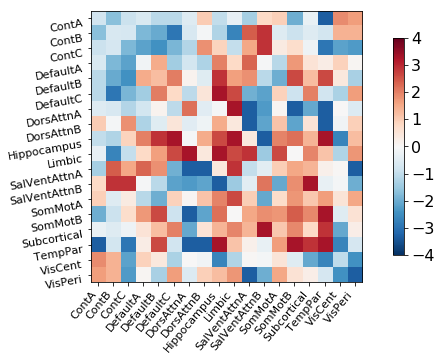

In [95]:
comb_cog_sys_dict=get_sys_zscores(conn_mat=combMat1,null_mat=comb_nullMat,
                                  node_df=schaefer_atlas,sys_names=sch_names,colindex='System',
                                  plot='unc',print_vals=True,thresh=True,alpha=0.025)

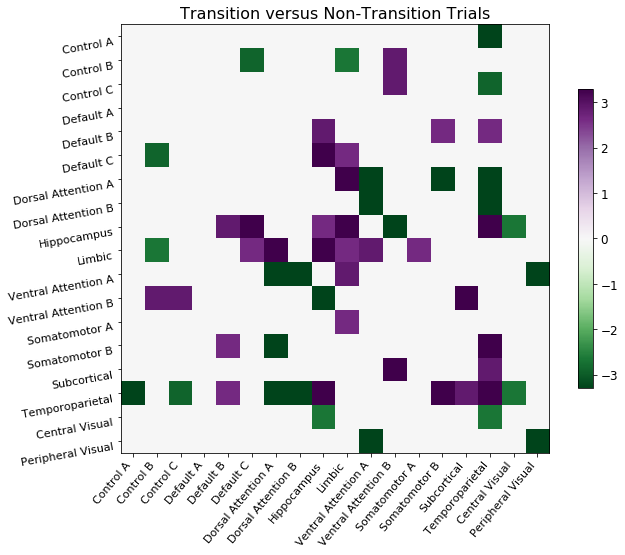

In [96]:

fig, ax1 = plt.subplots(figsize=(10,8))

display=plotting.plot_matrix(comb_cog_sys_dict['sys_df_zvals_fdr'],vmin=-3.3,vmax=3.3,cmap='PRGn_r',
                     labels=sys_labels,axes=ax1,colorbar=False,auto_fit=False)
plt.title('Transition versus Non-Transition Trials')
#fig.subplots_adjust(wspace=0.5)
cbar = plt.colorbar(display, ax = ax1, shrink = 0.7)
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig2d.svg'.format(path_Figures))

plt.show()

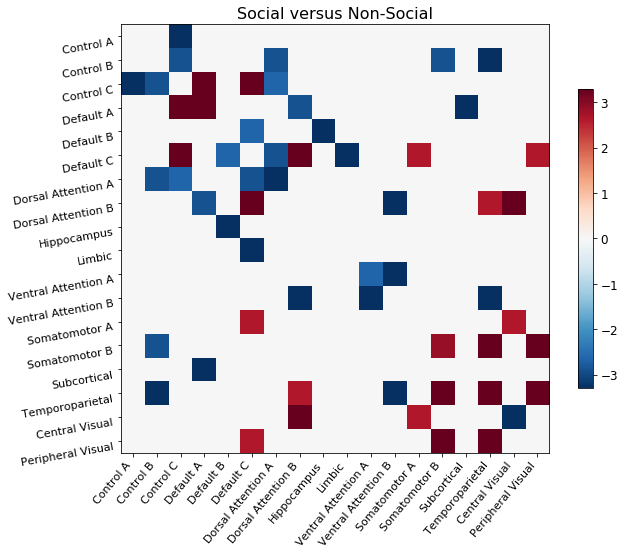

In [97]:
fig, ax1 = plt.subplots(figsize=(10,8))
#ax1.write_png('{}/diffmat_cogsys_fdr.png'.format(path_Figures))

display=plotting.plot_matrix(diff_cog_sys_dict['sys_df_zvals_fdr'],vmin=-3.3,vmax=3.3,
                     labels=sys_labels,axes=ax1,colorbar=False,auto_fit=False)

plt.title('Social versus Non-Social')
cbar = plt.colorbar(display, ax = ax1, shrink = 0.7)
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig3d.svg'.format(path_Figures))

# Figure 4A: Hub Connectivity Matrix for Social vs. Non-Social Contrast

In [98]:
def get_sys_zscores2(conn_mat,null_mat,syslist,
                     plot=True,thresh='fdr',alpha=0.025,print_vals=True):
    sys_names=syslist.keys()
    sys_names.sort()
    n_sys=len(syslist)
    sys_df=pd.DataFrame(np.zeros((n_sys,n_sys)))
    sys_df.index=sys_names
    sys_df.columns=sys_names
    sys_df_zvals=sys_df.copy()
    sys_df_pvals=sys_df.copy()
    
    for sys1 in sys_names:
        for sys2 in sys_names:
            sys_ix=syslist[sys1]
            sys_iy=syslist[sys2]
            #print('{}: {}'.format(sys1,sys_ix))
            #print('{}: {}'.format(sys2,sys_iy))
            sys_mean=get_means2(conn_mat,sys_ix,sys_iy)
            sys_null_dist=get_null_means2(np.expand_dims(null_mat,axis=0),sys_ix,sys_iy)
            sys_z,sys_p=compute_pval_twotail(sys_mean[0],sys_null_dist[0,:])
            if print_vals:
                print('{} x {} z={}, p={}'.format(sys1,sys2,sys_z,sys_p))
            sys_df.loc[sys1,sys2]=sys_mean
            sys_df_zvals.loc[sys1,sys2]=sys_z
            sys_df_pvals.loc[sys1,sys2]=sys_p

    if thresh=='fdr':
        reject_fdr,pval_fdr=fdr_correction(sys_df_pvals,alpha)
        sys_df_zvals=np.multiply(sys_df_zvals,reject_fdr)
    elif thresh=='unc':
        thmat=np.where(sys_df_pvals<alpha,1,0)
        sys_df_zvals=np.multiply(sys_df_zvals,thmat)
        
    sys_dict={'sys_df':sys_df,'sys_df_zvals':sys_df_zvals,'sys_df_pvals':sys_df_pvals}
    
    if plot:
        ax=plotting.plot_matrix(sys_df_zvals,vmin=-4,vmax=4,labels=sys_names)
        plt.show()
    return sys_dict

In [99]:
def sub_dict_remove1(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return tdict

def sub_dict_remove2(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return dict((k, v) for k, v in tdict.iteritems() if v)

sigdic_rois={'ns_hub':sigdic_diff_ns.copy(),
             'soc_hub':sigdic_diff.copy(),
             'comb_hub':sigdic_comb.copy()}

for key in sigdic_rois:
    sigdic_rois[key]=sub_dict_remove2(sigdic_rois[key],roi_names)
    
syslist_rois={}
for k1 in sigdic_rois.keys():
    for k2 in sigdic_rois[k1].keys():
        syslist_rois['{}_{}'.format(k1,k2)]=sigdic_rois[k1][k2]
                
print('{} hubs in syslist_rois'.format(len(syslist_rois)))

keys1=[key for key in syslist_rois.keys() if 'soc' in key or 'ns' in key or 'Hippocampus_' in key]

syslist_rois2=sub_dict_remove2(syslist_rois,keys1)

syslist_rois2

14 hubs in syslist_rois


{'comb_hub_Hippocampus_L': [402],
 'comb_hub_Hippocampus_R': [407],
 'ns_hub_dmPFC_L': [165, 177],
 'ns_hub_dmPFC_R': [310, 370, 371, 376, 378],
 'ns_hub_lPFC_L': [182],
 'ns_hub_lPFC_R': [308, 332, 304],
 'soc_hub_TPJ_L': [85, 172],
 'soc_hub_TPJ_R': [262, 394, 396, 397]}

comb_hub_Hippocampus_L x comb_hub_Hippocampus_L z=0.00250663089957, p=0.499
comb_hub_Hippocampus_L x comb_hub_Hippocampus_R z=-1.6072478919, p=0.054
comb_hub_Hippocampus_L x ns_hub_dmPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_L x ns_hub_dmPFC_R z=-1.97736842818, p=0.024
comb_hub_Hippocampus_L x ns_hub_lPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_L x ns_hub_lPFC_R z=-0.150969215497, p=0.44
comb_hub_Hippocampus_L x soc_hub_TPJ_L z=1.12639112904, p=0.13
comb_hub_Hippocampus_L x soc_hub_TPJ_R z=0.848786685916, p=0.198
comb_hub_Hippocampus_R x comb_hub_Hippocampus_L z=-1.6072478919, p=0.054
comb_hub_Hippocampus_R x comb_hub_Hippocampus_R z=0.00250663089957, p=0.499
comb_hub_Hippocampus_R x ns_hub_dmPFC_L z=-1.91103564755, p=0.028
comb_hub_Hippocampus_R x ns_hub_dmPFC_R z=-0.524400512708, p=0.3
comb_hub_Hippocampus_R x ns_hub_lPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_R x ns_hub_lPFC_R z=-1.35317415455, p=0.088
comb_hub_Hippocampus_R x soc_hub_TPJ_L z=-0.765456096691,

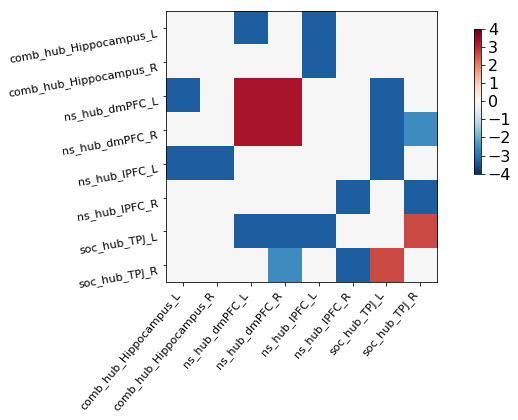

In [100]:
sys_scores_fdr={}
sys_scores_fdr['diff2']=get_sys_zscores2(diffMat1,diff_nullMat,syslist_rois2,
                                         plot=True,thresh='fdr',print_vals=True)

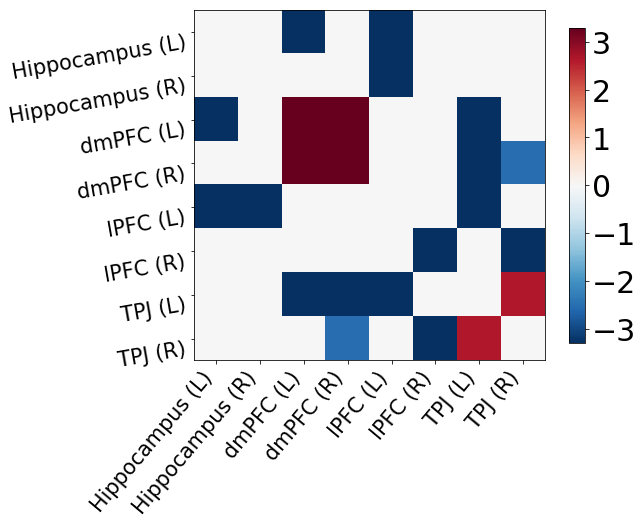

In [101]:

newlabs=['Hippocampus (L)','Hippocampus (R)',
         'dmPFC (L)','dmPFC (R)',
        'lPFC (L)','lPFC (R)',
        'TPJ (L)','TPJ (R)']

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(10,8))
display=plotting.plot_matrix(sys_scores_fdr['diff2']['sys_df_zvals'],vmin=-3.3,vmax=3.3,labels=newlabs,axes=ax1,colorbar=False,auto_fit=False)

#plt.title('Social versus Non-Social')
#fig.subplots_adjust(wspace=0.5)
cbar = plt.colorbar(display, ax = ax1, shrink = 0.9)
#cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig4a.svg'.format(path_Figures))

# Figure 4B: Connectivity between hippocampus and other hubs for social versus non-social contrast

In [102]:
sch_coords=zip(schaefer_atlas.loc[:,'x'],schaefer_atlas.loc[:,'y'],schaefer_atlas.loc[:,'z'])

Shape of matrix is (69, 69)
Shape of matrix is (69, 69)
Mean effect size for displayed edges=0.114421615456
Shape of matrix is (59, 59)
Shape of matrix is (59, 59)
Mean effect size for displayed edges=-0.118841956318


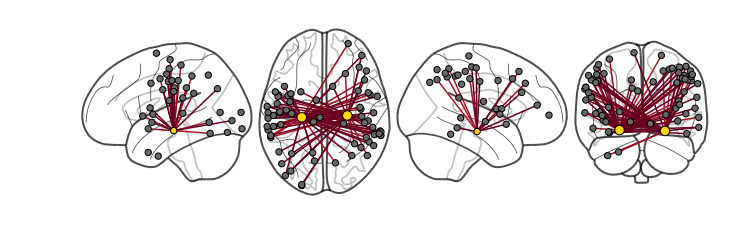

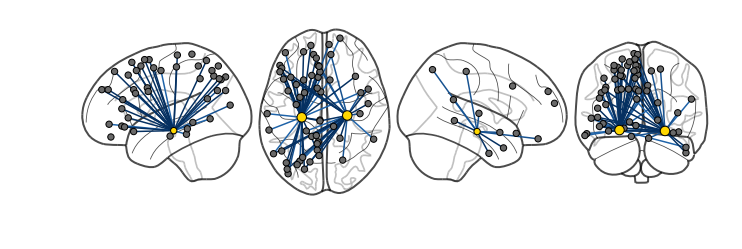

In [103]:
def load_data(task,namestr,roi,thresh=True,alpha=0.025,filt_ix=None):
    data=np.load(opj(path_OutpData,'netLearn_{}_{}_{}.npz'.format(task,namestr,roi)))
    #data=np.load('{}/netLearn_{}_{}.npz'.format(path_OutpData,yy,xx))
    zMat=data['zMat']
    #pMat=np.multiply(data['pMat'],2)
    pMat=data['pMat']
    #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
    #a less arbitrary z=3.29 or z=-3.29
    #which should be greater than max value so long as len(null_dist)<2000
    zMat[zMat==4]=ss.norm.ppf(.9995)
    zMat[zMat==-4]=ss.norm.ppf(.0005)

    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)
    if filt_ix:
        zMat[filt_ix]=0
    return zMat

def sub_matrix(subjMat,ixes):
    if subjMat.ndim==3:
        newMat=subjMat[:,ixes,:]
        newMat=newMat[:,:,ixes]
    else:
        newMat=subjMat[ixes,:]
        newMat=newMat[:,ixes]        
    print('Shape of matrix is {}'.format(newMat.shape))
    return newMat



def plot_connectomes(mat_ix,df1,figTitle,net_coords,mat_cols=None,node_sizes=None,figName=None,nodeMethod='All',nodeThresh=95,
                     eMethod='All',eThresh="95%",figtype='svg'):
    df1=sub_matrix(df1,mat_ix)
    mat_coords=np.array(net_coords)[mat_ix]
    if mat_cols is None:
        mat_cols=np.array(['dimgray']*len(mat_ix))
    else:
        mat_cols=np.array(mat_cols)[mat_ix]
        
    if node_sizes is None:
        node_sizes=np.array([30]*len(mat_ix))
    else:
        node_sizes=np.array(node_sizes)[mat_ix]
    #df1=np.mean(medMat,axis=0)
    rowMeans=np.mean(df1,axis=1)
    rowCount=np.sum(df1!=0,axis=1)
    
    if nodeMethod=='All':
        sub_ixes=range(df1.shape[0])
    elif nodeMethod=='Count':
        sub_ixes=np.where(rowCount>np.percentile(rowCount,nodeThresh))[0]
    elif nodeMethod=='Mean':
        sub_ixes=np.where(rowMeans>np.percentile(rowMeans,nodeThresh))[0]
        
    #cv_edges=np.where(np.abs(df1)>.6,1,0)
    cv_edges=sub_matrix(df1,sub_ixes)
    cv_coords=mat_coords[sub_ixes]
    cv_colors=mat_cols[sub_ixes].tolist()
    cv_sizes=node_sizes[sub_ixes].tolist()
    
    if eMethod=='None':
        cv_edges=np.zeros(cv_edges.shape)
    plotting.plot_connectome(cv_edges, cv_coords, 
                             display_mode = 'lzry', 
                             annotate = False,
                             node_color= cv_colors,
                             node_size=cv_sizes,
                             edge_cmap='RdBu_r',
                             edge_threshold=eThresh,
                             edge_kwargs={'linewidth':1.5},node_kwargs={'linewidths':1,'edgecolor':'black'})
                             #title = figTitle);
    if figName:
        plt.savefig('{}/{}.{}'.format(path_Figures,figName,figtype))
    print('Mean effect size for displayed edges={}'.format(np.mean(cv_edges)))

def hipp_conn_plot(task,namestr,figtitle='',flip=False,valence='pos',roi_ix='all',savename=None):
    conn_mat=np.zeros((n_node,n_node))
    
    hcolors=np.array(['dimgray']*n_node)
    hsizes=np.array([40]*n_node)
    for rr in ['Hippocampus_L','Hippocampus_R']:
        roi_zMat=load_data(task=task,namestr=namestr,roi=rr)
        col_ix=np.where(schaefer_atlas['ns_ROI_label']==rr)[0][0]
        conn_mat[:,col_ix]=np.expand_dims(roi_zMat,axis=0)
        conn_mat[col_ix,:]=np.expand_dims(roi_zMat,axis=0)   
        hcolors[col_ix]='gold'
        hsizes[col_ix]=90
    if flip:
        conn_mat=np.multiply(conn_mat,-1)
        
    if valence=='pos':
        pos_mat=conn_mat.copy()
        pos_mat[pos_mat<0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(pos_mat,axis=0)!=0)[0],pos_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,pos_mat,figtitle,sch_coords)
    elif valence=='neg':
        neg_mat=conn_mat.copy()
        neg_mat[neg_mat>0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(neg_mat,axis=0)!=0)[0],neg_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,neg_mat,figtitle,sch_coords)
            
hipp_conn_plot('diffData','zscores_combhubs','Social vs. Non-Social',savename='fig4b_pos')
hipp_conn_plot('diffData','zscores_combhubs','Non-Social vs. Social',valence='neg',savename='fig4b_neg')

In [104]:
def hub_conn_plot(task,namestr,hublist,figtitle='',flip=False,valence='pos',roi_ix='all',savename=None):
    conn_mat=np.zeros((n_node,n_node))
    
    hcolors=np.array(['dimgray']*n_node)
    hsizes=np.array([40]*n_node)
    for rr in hub_list:
        roi_zMat=load_data(task=task,namestr=namestr,roi=rr)
        col_ix=np.where(schaefer_atlas['ns_ROI_label']==rr)[0][0]
        conn_mat[:,col_ix]=np.expand_dims(roi_zMat,axis=0)
        conn_mat[col_ix,:]=np.expand_dims(roi_zMat,axis=0)   
        hcolors[col_ix]='gold'
        hsizes[col_ix]=90
    if flip:
        conn_mat=np.multiply(conn_mat,-1)
        
    if valence=='pos':
        pos_mat=conn_mat.copy()
        pos_mat[pos_mat<0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(pos_mat,axis=0)!=0)[0],pos_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,pos_mat,figtitle,sch_coords)
    elif valence=='neg':
        neg_mat=conn_mat.copy()
        neg_mat[neg_mat>0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(neg_mat,axis=0)!=0)[0],neg_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,neg_mat,figtitle,sch_coords)

# Supplementary Figures: Plot GLM Results

In [10]:
os.listdir(opj(data_dir,'Subject_Data','netLearn_glm'))

['secondLevel', '.DS_Store', 'firstLevel', 'results_zmaps']

In [11]:
glm_path=opj(data_dir,'Subject_Data','netLearn_glm')

def plot_zmap(img_name,img_folder='',alpha=0.001,thresh=False,tmode='fdr',savename='',
              save=False,plot=False,effect='pos',dmode='ortho',ccoords=[-10,-10,10]):

    #Load nii image
    mimg=nb.load(opj(glm_path,'secondLevel',img_name))
    if effect=='neg':
        mimg=image.math_img('img1*-1',img1=mimg)
        
    if thresh:
        new_img,thr=thresholding.map_threshold(stat_img=mimg,
                                               level=alpha,
                                               height_control=tmode,
                                               cluster_threshold=5)
    else:
        new_img=mimg
        
    if effect=='neg':
        new_img=image.math_img('img1*-1',img1=new_img)

    savefolder=opj(glm_path,'results_zmaps')
    if not os.path.exists(savefolder):
        os.makedirs(savefolder)
    
    savefile = '{}/{}_{}.nii.gz'.format(savefolder,savename,effect)
    nb.save(new_img,savefile)
    
    if plot:
        plotting.plot_stat_map(savefile,display_mode=dmode,cut_coords=ccoords,title=savename)
    
    return new_img

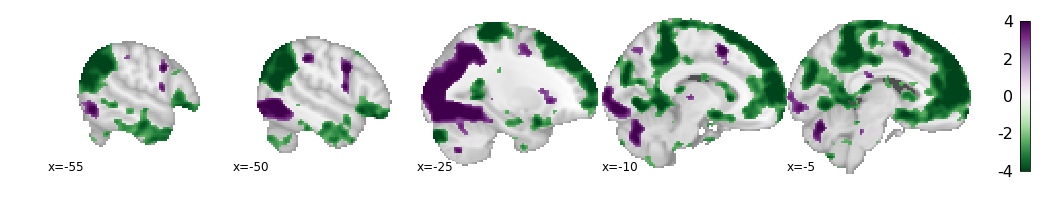

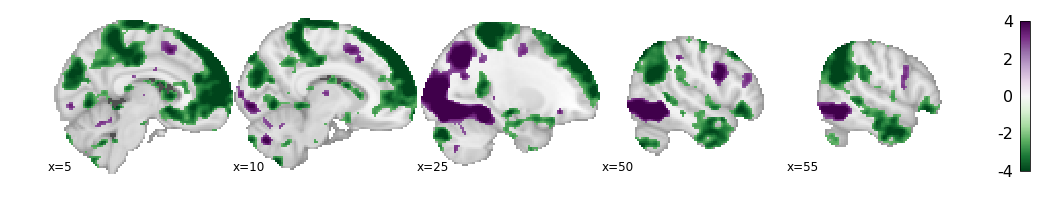

In [31]:
pos_img1=plot_zmap(img_name='netLearn_interceptXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='transition_contrast_thresh',plot=False)

neg_img1=plot_zmap(img_name='netLearn_interceptXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',effect='neg',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='transition_contrast_thresh',plot=False)

cimg1=image.math_img('img1+img2',img1=pos_img1,img2=neg_img1)
d1=plotting.plot_stat_map(cimg1,display_mode='x',cut_coords=[-55,-50,-25,-10,-5],cmap='PRGn_r',vmax=4)
d2=plotting.plot_stat_map(cimg1,display_mode='x',cut_coords=[5,10,25,50,55],cmap='PRGn_r',vmax=4)
d1.savefig('{}/glm_transition_contrast_fig_lh.svg'.format(path_Figures))
d2.savefig('{}/glm_transition_contrast_fig_rh.svg'.format(path_Figures))

'/Users/steventompson/Dropbox/Manuscripts/In_Progress/Tompson_SNL_fMRI/Figures/component_figs'

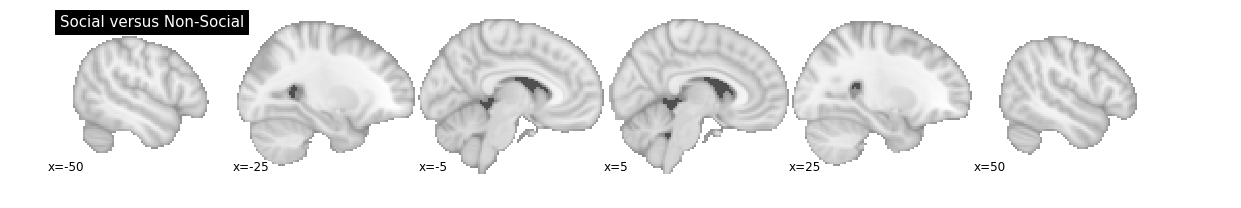

In [18]:
pos_img2=plot_zmap(img_name='netLearn_condXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='condXtransition_contrast_thresh',plot=False)

neg_img2=plot_zmap(img_name='netLearn_condXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',effect='neg',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='condXtransition_contrast_thresh',plot=False)

cimg2=image.math_img('img1+img2',img1=pos_img2,img2=neg_img2)
d1=plotting.plot_stat_map(cimg2,display_mode='x',cut_coords=[-50,-25,-5])
d2=plotting.plot_stat_map(cimg2,display_mode='x',cut_coords=[5,25,50])
#d1.savefig('{}/{}_{}_lh.{}'.format(path_Figures,yy,xx,figtype))
#d2.savefig('{}/{}_{}_rh.{}'.format(path_Figures,yy,xx,figtype))